<a href="https://colab.research.google.com/github/alienverarslan/CarInsuranceSalesPrediction/blob/main/CarInsuranceSalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import missingno
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, cross_validate
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
sns.set()
!pip install category_encoders 
import category_encoders as ce

In [ ]:
data = pd.read_excel("Arac_train.xlsx")
data.head()

,Musteri_no,Cinsiyet,Yas,Ehliyet,Sehir,Gecmis_police,Arac_yasi,Hasar_durumu,Yillik_prim,Acenta_no,Sure,Sonuc
0,301236,E,1985,Var,Ordu,Yok,1-2 Yil,E,2960.00,147,131,0
1,360545,E,1990,Var,Gaziantep,Var,< 1 Yil,H,3081.78,177,213,0
2,124745,E,1990,Var,Kocaeli,Yok,< 1 Yil,E,3672.67,177,72,0
3,72320,E,1995,Var,Izmir,Var,< 1 Yil,H,3599.89,177,117,0
4,226178,E,1998,Var,Kocaeli,Yok,< 1 Yil,E,3697.22,177,177,0


**Missing Data Analysis**

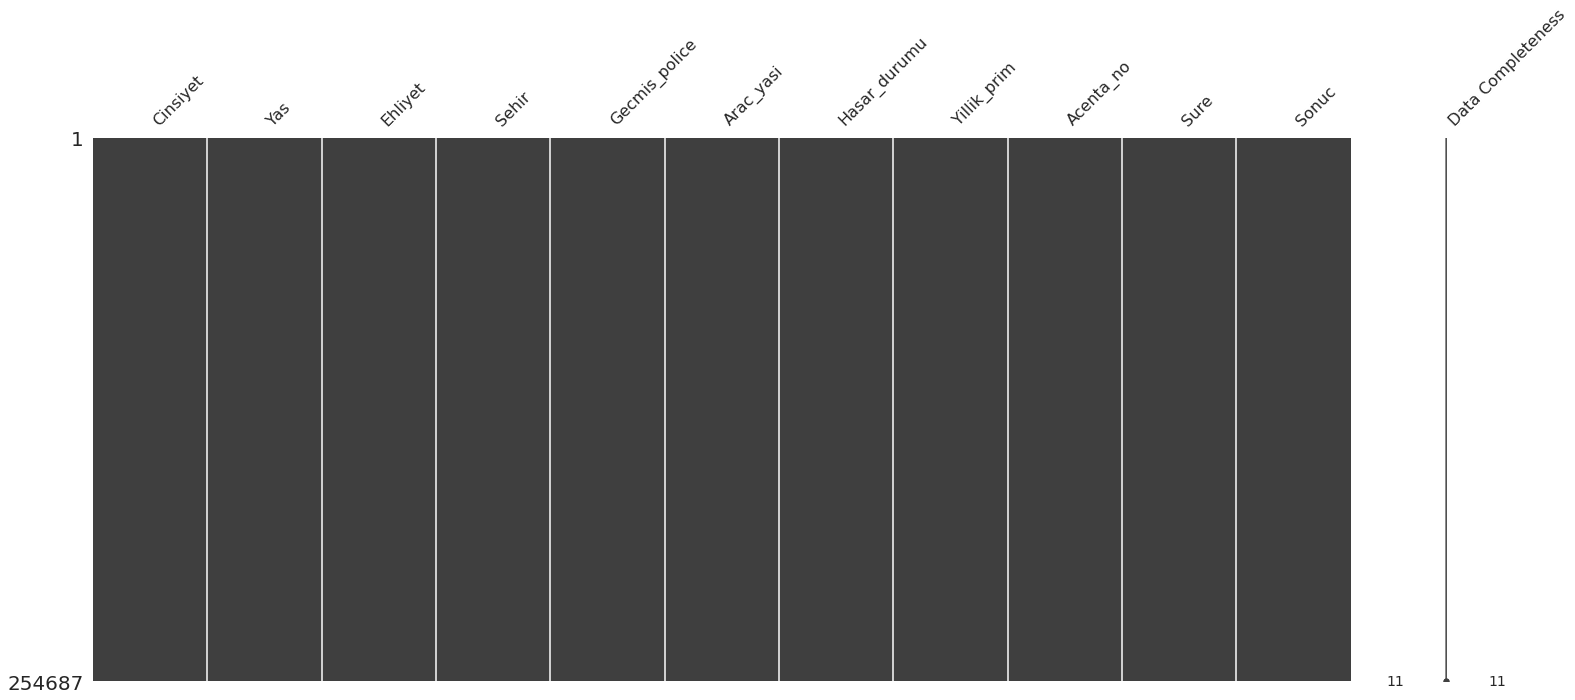

In [ ]:
missingno.matrix(data.drop('Musteri_no', axis=1), labels=True)
plt.show()

There is no missing data at all in the dataset.

In [ ]:
data.describe()

,Musteri_no,Yas,Yillik_prim,Acenta_no,Sure,Sonuc
count,254687.000000,254687.000000,254687.000000,254687.000000,254687.000000,254687.000000
mean,210690.852466,1981.603808,4009.912447,136.736661,154.433901,0.122232
std,110048.219016,15.588384,1452.612644,53.897345,83.694218,0.327555
min,20001.000000,1935.000000,292.220000,26.000000,9.000000,0.000000
25%,115379.500000,1971.000000,3153.440000,54.000000,82.000000,0.000000
50%,210577.000000,1985.000000,3768.000000,149.000000,154.000000,0.000000
75%,306056.500000,1996.000000,4588.220000,177.000000,227.000000,0.000000
max,401109.000000,2000.000000,60018.330000,188.000000,300.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254687 entries, 0 to 254686
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Musteri_no     254687 non-null  int64  
 1   Cinsiyet       254687 non-null  object 
 2   Yas            254687 non-null  int64  
 3   Ehliyet        254687 non-null  object 
 4   Sehir          254687 non-null  object 
 5   Gecmis_police  254687 non-null  object 
 6   Arac_yasi      254687 non-null  object 
 7   Hasar_durumu   254687 non-null  object 
 8   Yillik_prim    254687 non-null  float64
 9   Acenta_no      254687 non-null  int64  
 10  Sure           254687 non-null  int64  
 11  Sonuc          254687 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 23.3+ MB


We have both numeric and categoric features

Since Musteri_no is the id column, we do not need it in the model

In [ ]:
data = data.drop("Musteri_no", axis=1)

We will treat Acenta_no as a categorical data

In [ ]:
data["Acenta_no"] = data["Acenta_no"].astype("object")

In [ ]:
numeric_features = []
categoric_features = []

for col in data.drop("Sonuc", axis=1).columns:
  if data[col].dtype == 'object':
    categoric_features.append(col)
  else:
    numeric_features.append(col)

print("categoric feature list:", categoric_features)
print("numeric feature list:", numeric_features)    

categoric feature list: ['Cinsiyet', 'Ehliyet', 'Sehir', 'Gecmis_police', 'Arac_yasi', 'Hasar_durumu', 'Acenta_no']
numeric feature list: ['Yas', 'Yillik_prim', 'Sure']


**How the target looks like?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


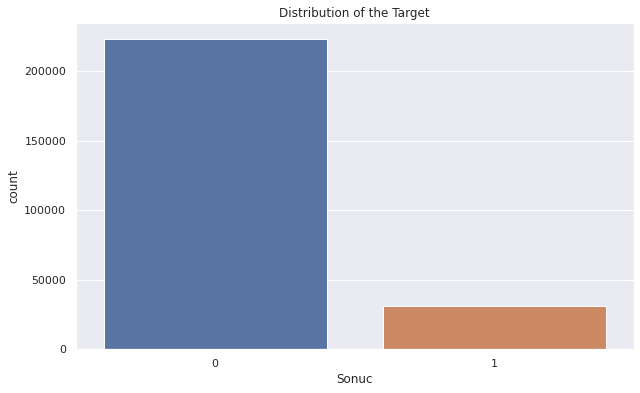

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data['Sonuc'])
plt.title("Distribution of the Target")
plt.show()

We have a highly imbalanced dataset!

**The relationship between categorical features and the target**

Before investigating the relationship between target and the independent variables, we split our data into train and test splits.

In [ ]:
X = data.drop("Sonuc", axis=1)
y = data["Sonuc"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
train_set = pd.concat([X_train, y_train], axis=1)

In [ ]:
train_set[categoric_features].nunique()

Cinsiyet           2
Ehliyet            2
Sehir             53
Gecmis_police      2
Arac_yasi          5
Hasar_durumu       2
Acenta_no        140
dtype: int64

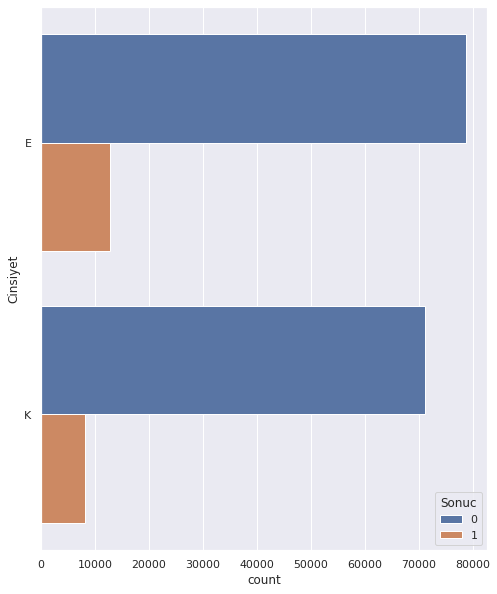

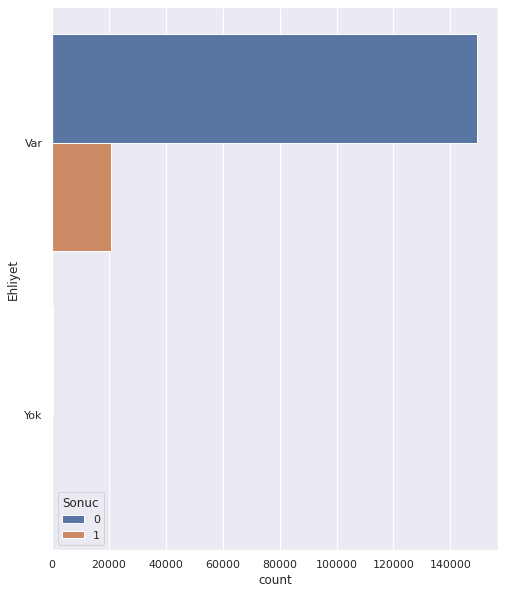

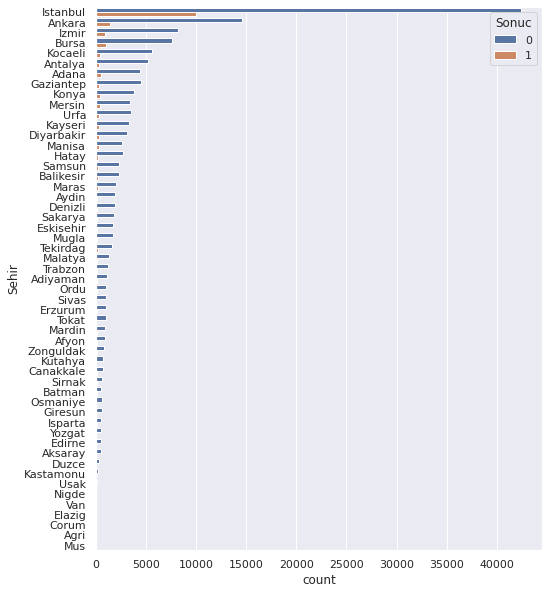

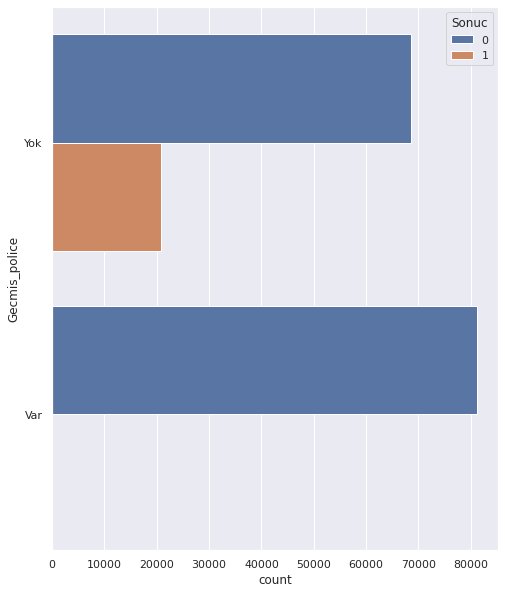

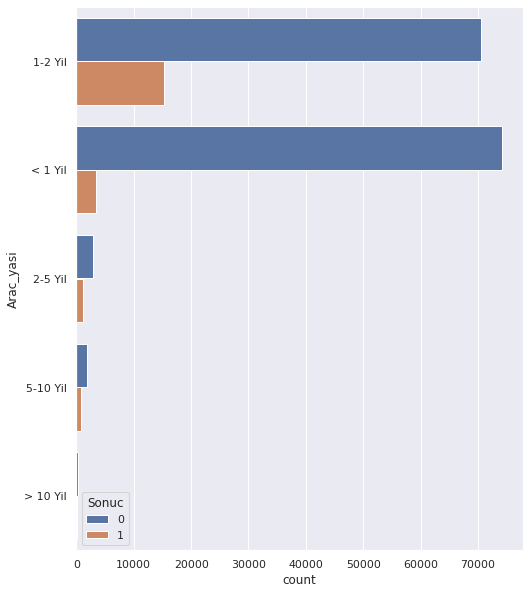

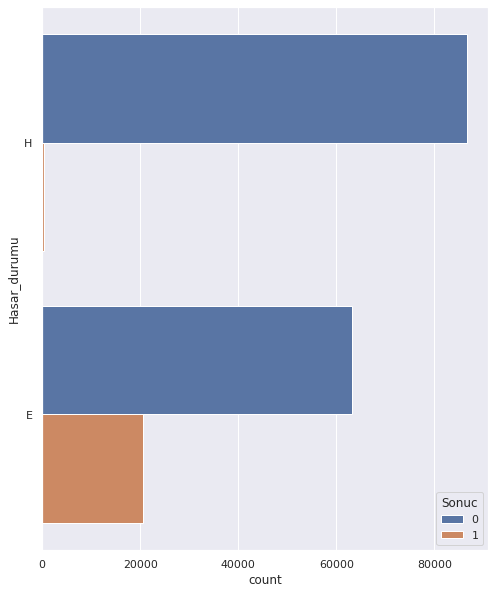

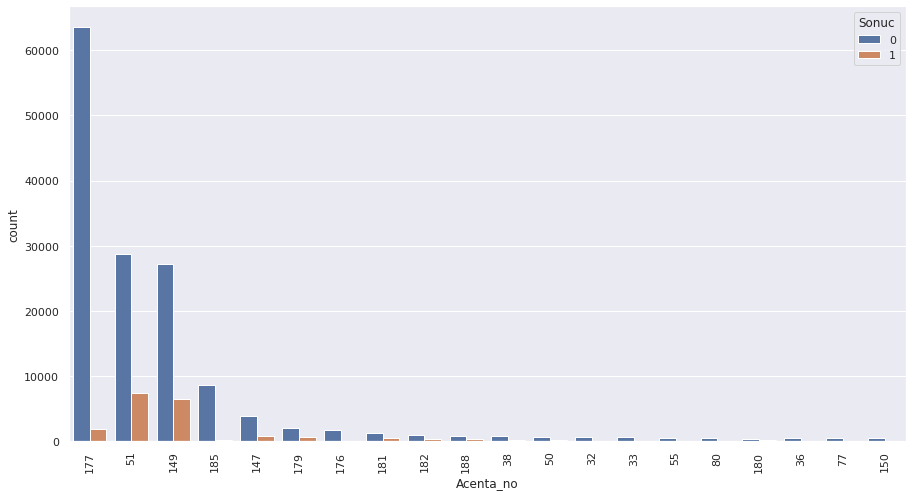

In [ ]:
for i in categoric_features:
  if i == 'Acenta_no':
    plt.figure(figsize=(15, 8))
    sns.countplot(x=i, hue="Sonuc", data=train_set, order=train_set[i].value_counts().iloc[:20].index)
    plt.xticks(rotation=90)
  else:
    plt.figure(figsize=(8, 10))
    sns.countplot(y=i, hue="Sonuc", data=train_set, order=train_set[i].value_counts().iloc[:len(train_set[i])].index)


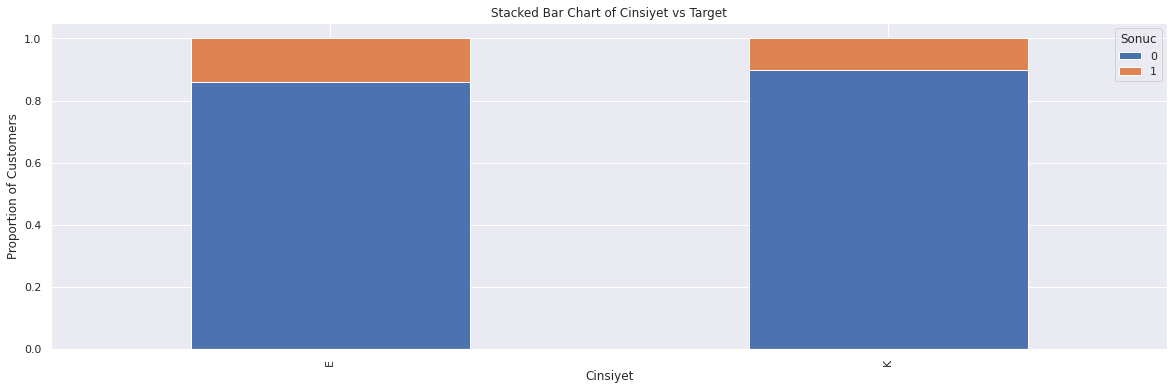

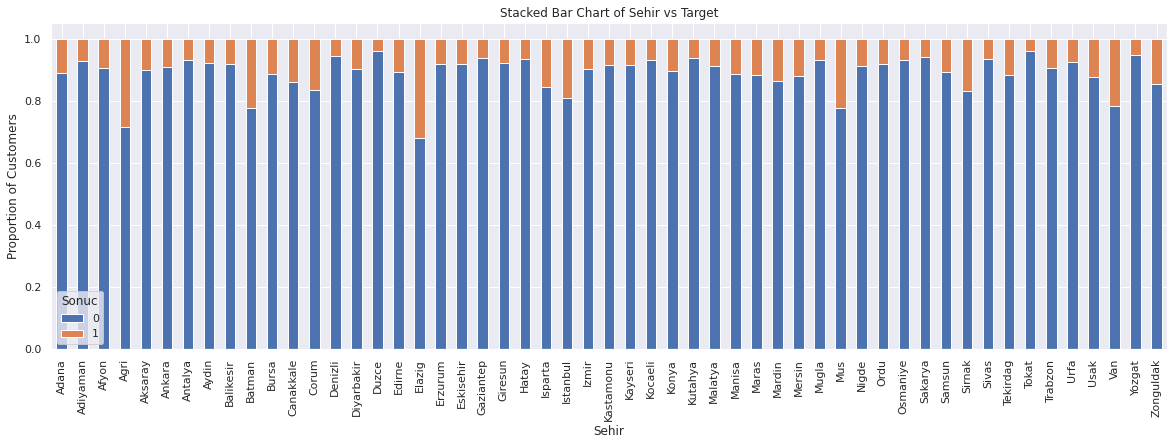

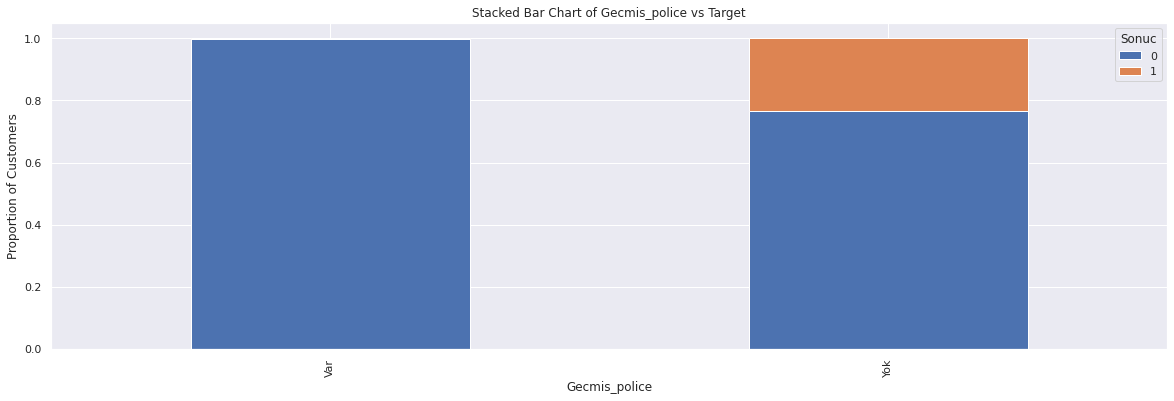

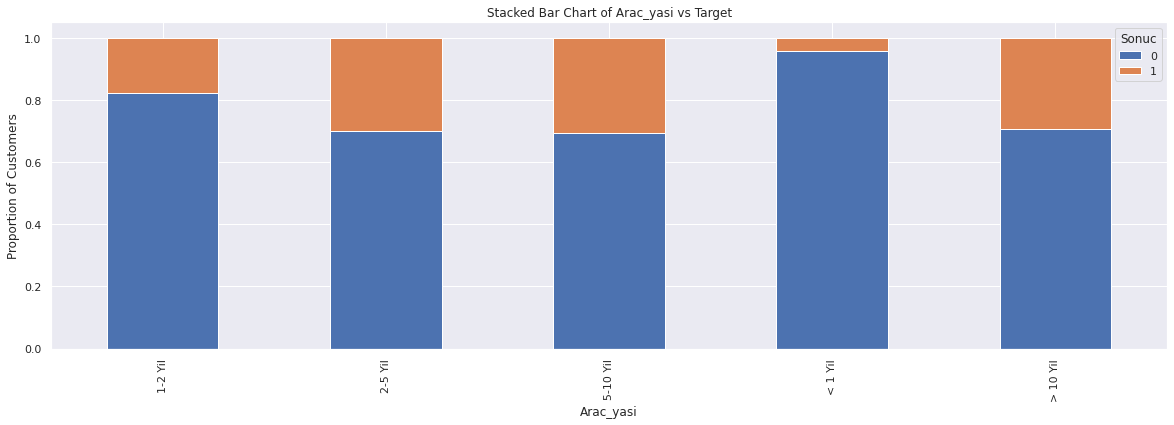

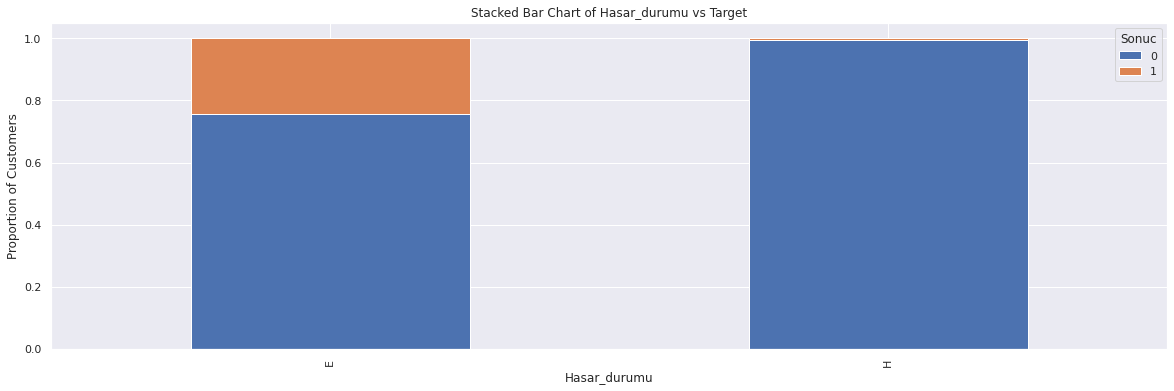

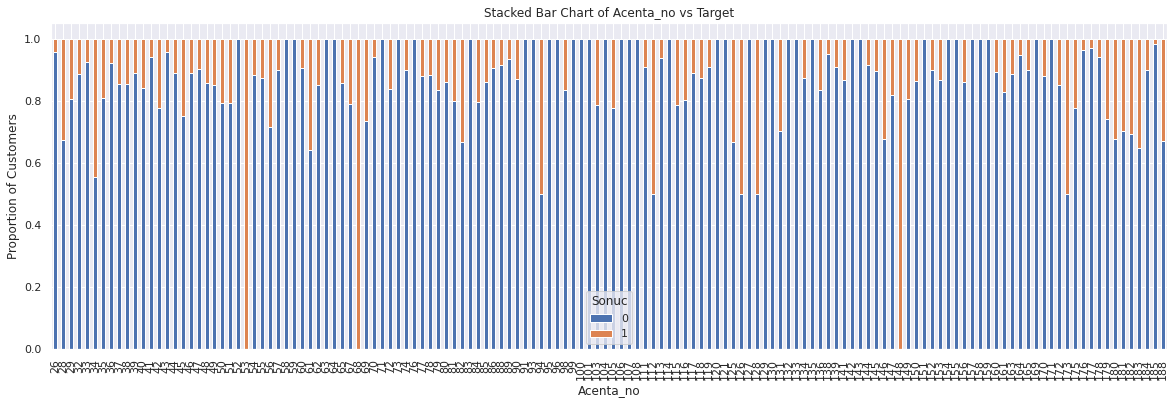

In [ ]:
for col in categoric_features:
  table=pd.crosstab(train_set[col], train_set["Sonuc"])
  table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', figsize=(20,6), stacked=True)
  plt.title('Stacked Bar Chart of {} vs Target'.format(col))
  plt.xlabel(col)
  plt.xticks(rotation=90)
  plt.ylabel('Proportion of Customers')
  plt.show()

* Since Ehliyet feature does not have any variance, it will not be useful for our model. Hence, we drop that feature from the dataset. 
* Cinsiyet has similar distribution for both values of the target.
* There is concentration on small number of cities.
* Hasar_durumu have a distinguishing distribution for the target.
* There is some useful information on the Acenta_no 177, 51, 185 and 149. 
* Gecmis_police shows that if the customer has a previous policy s/he has no intention for the company's offer at all.
* In Agrı, Batman, Elazıg, Muş and Van, the success rate differentiates from the other cities. 
* In Acenta_no 53, 68, 94, 112 and 148 success rate differentiates from the other agents.
 

In [ ]:
train_set = train_set.drop("Ehliyet", axis=1)
X_train = X_train.drop("Ehliyet", axis=1)
X_test = X_test.drop("Ehliyet", axis=1)
categoric_features.remove("Ehliyet")

**The relationship between numerical features and the target**

Firstly, I am going to convert **Yas** feature from year to age.

In [ ]:
train_set["Yas"] = 2021 - train_set["Yas"]
X_train["Yas"] = 2021 - X_train["Yas"]
X_test["Yas"] = 2021 - X_test["Yas"] 

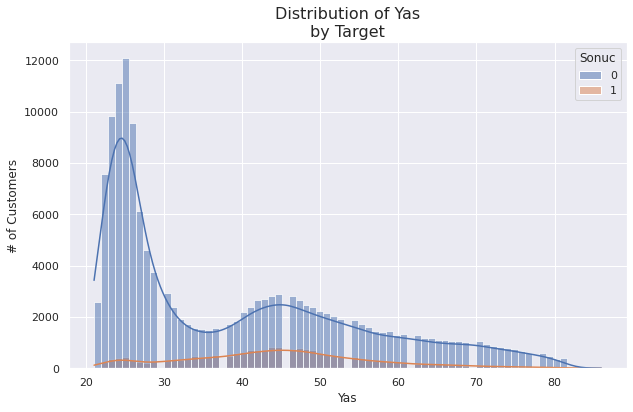

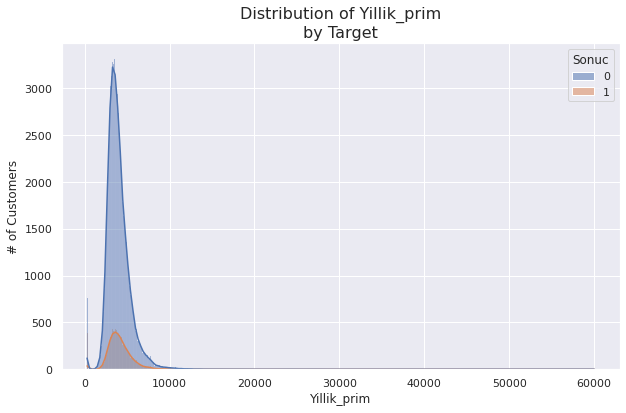

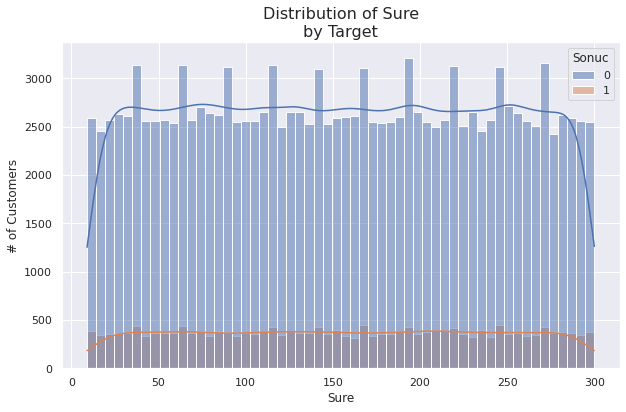

In [ ]:
for i, j in enumerate(numeric_features):
  plt.figure(figsize=(10, 6))
  sns.histplot(data=train_set, x=j, hue='Sonuc', kde=True)
  plt.title('Distribution of {}\nby Target'.format(j), fontsize=16)
  plt.ylabel('# of Customers')
  plt.show()

* From the cahrts above, we can see that **Yas** has different distribution for each value of the target and there is concentration towards younger ages.

* **Yillik_prim** has a right-skewed distribution and it is similar for both values of the target
* **Sure** also has a similar distributions for both target values but its distribution is similar to uniform.



**Feature Engineering**

Now we will do some feature engineering in a way that increases our prediction ability on the target.

*Categoric Features*

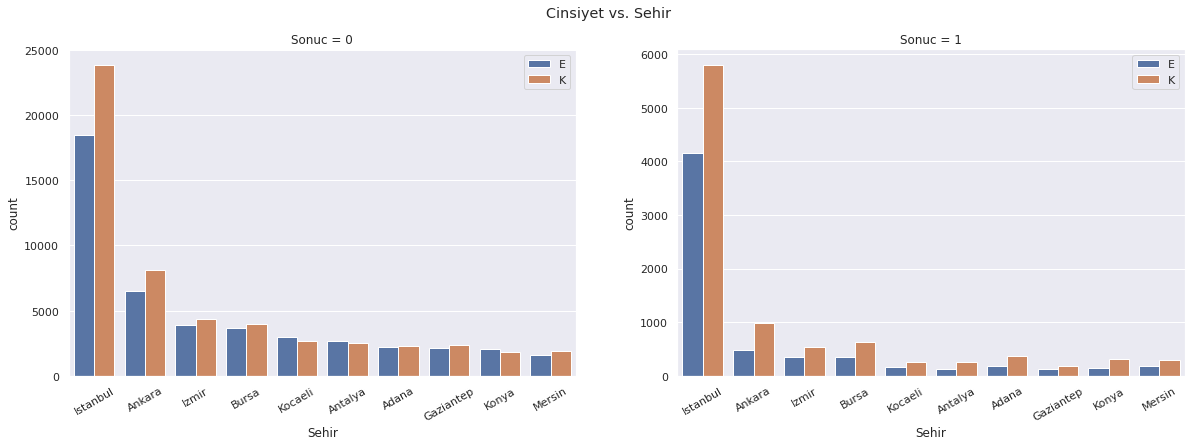

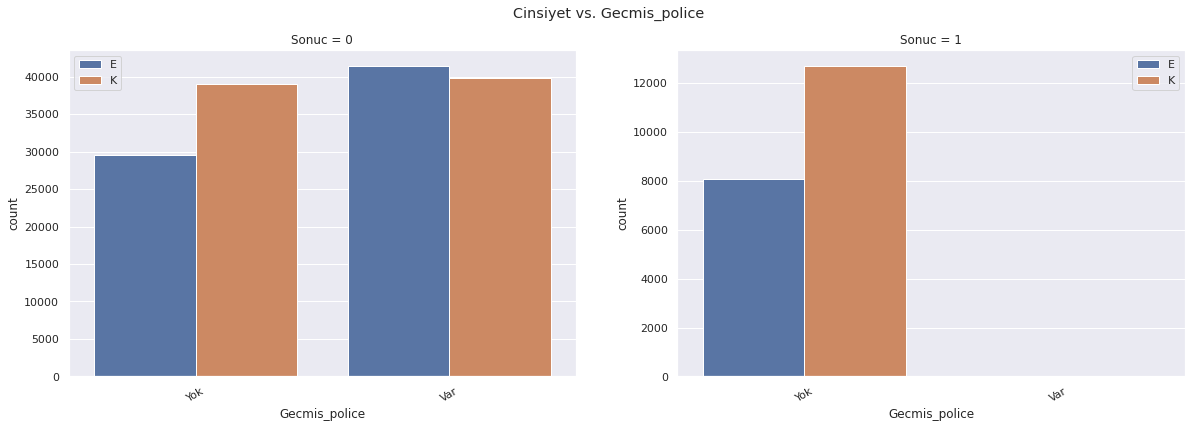

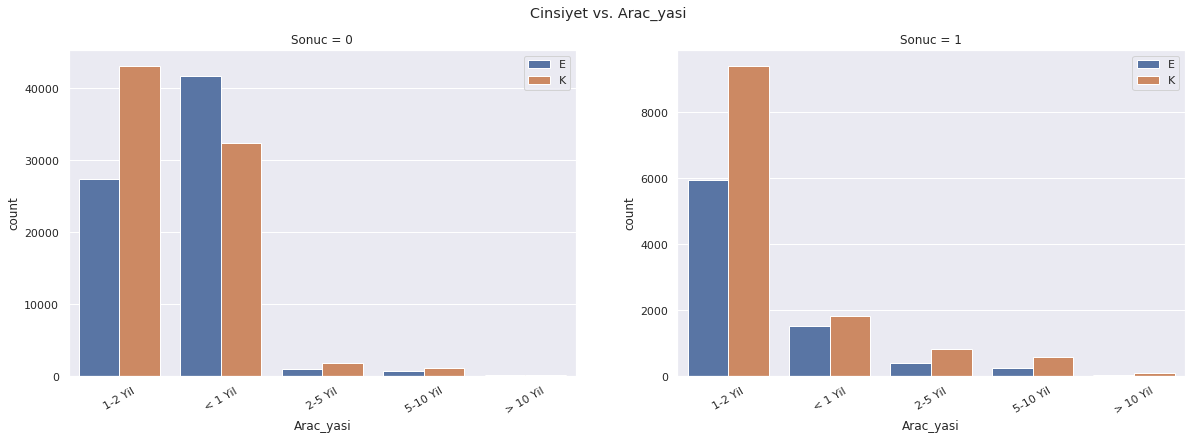

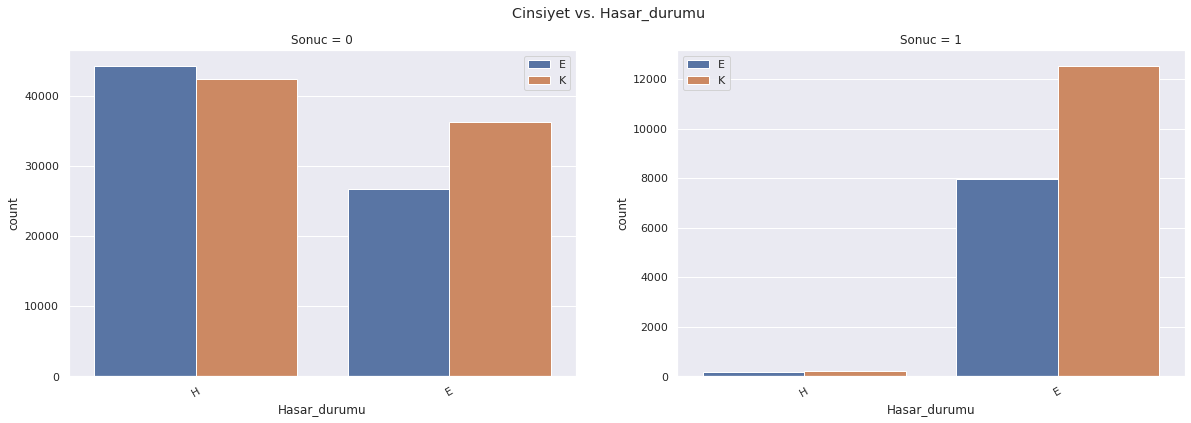

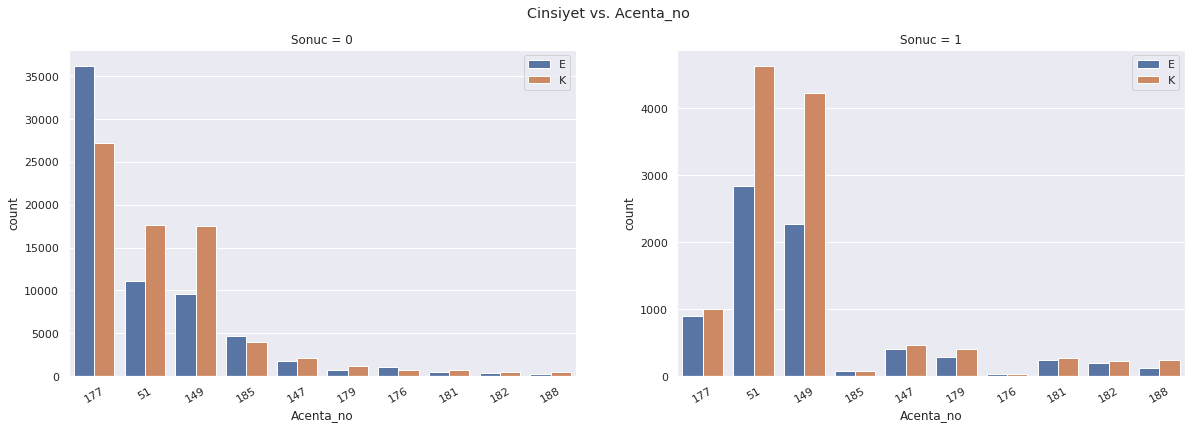

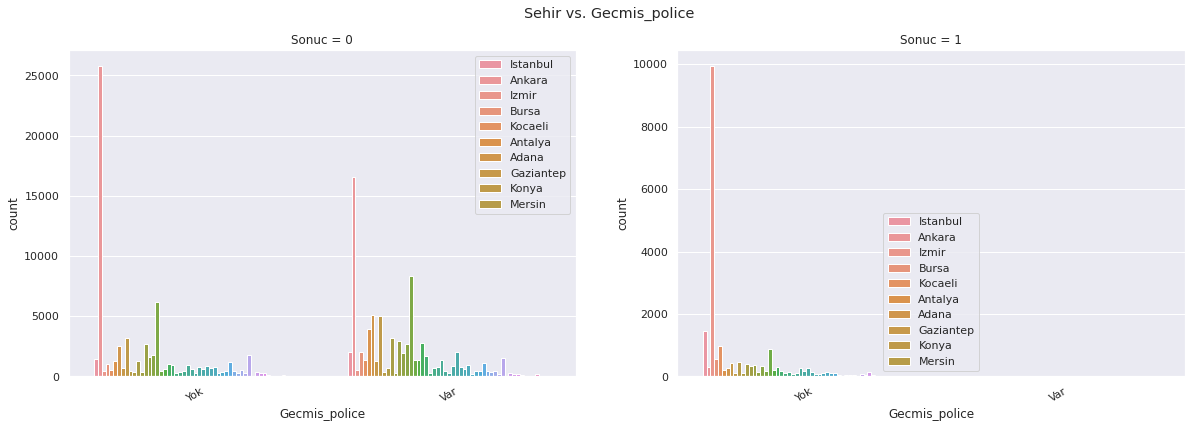

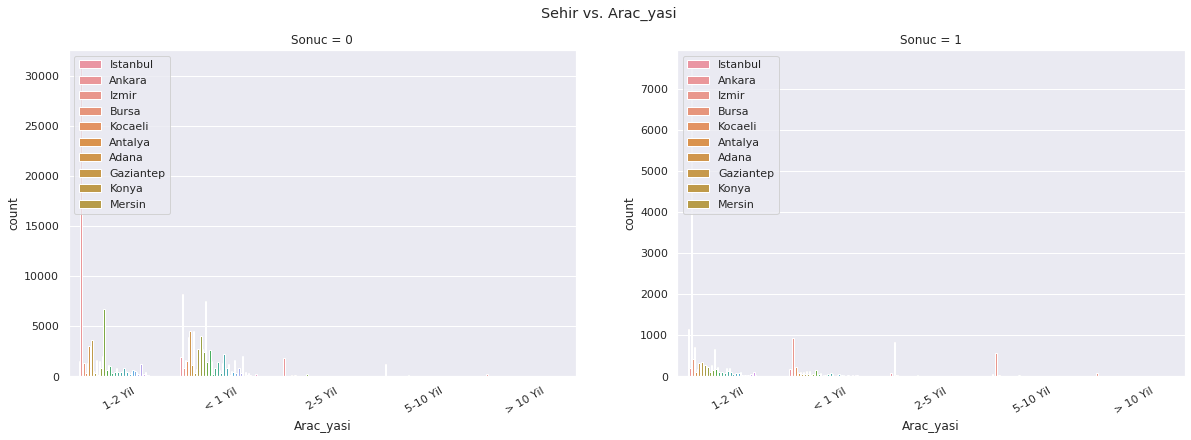

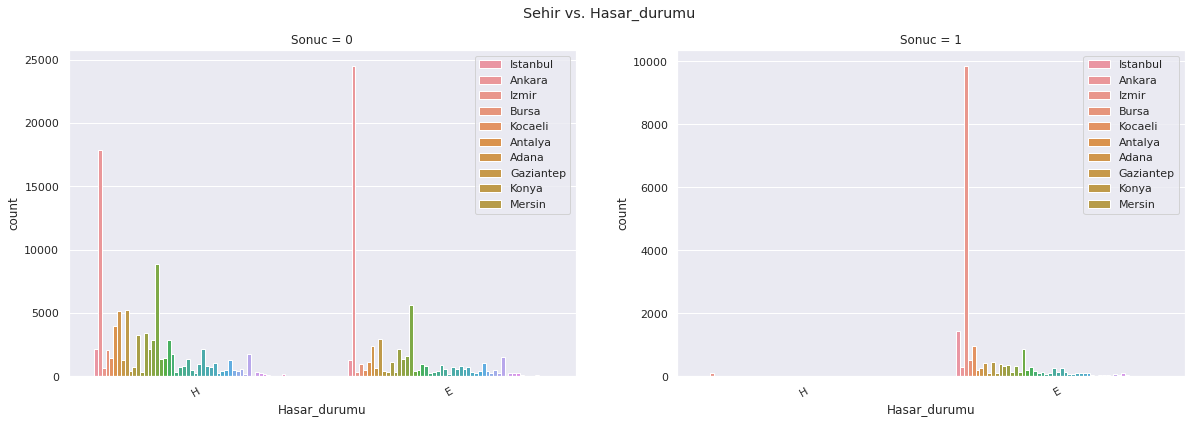

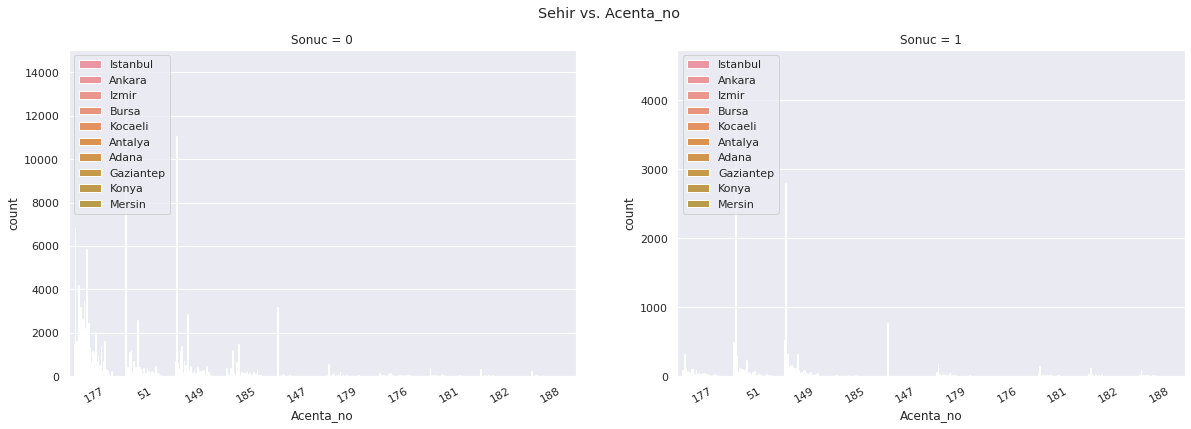

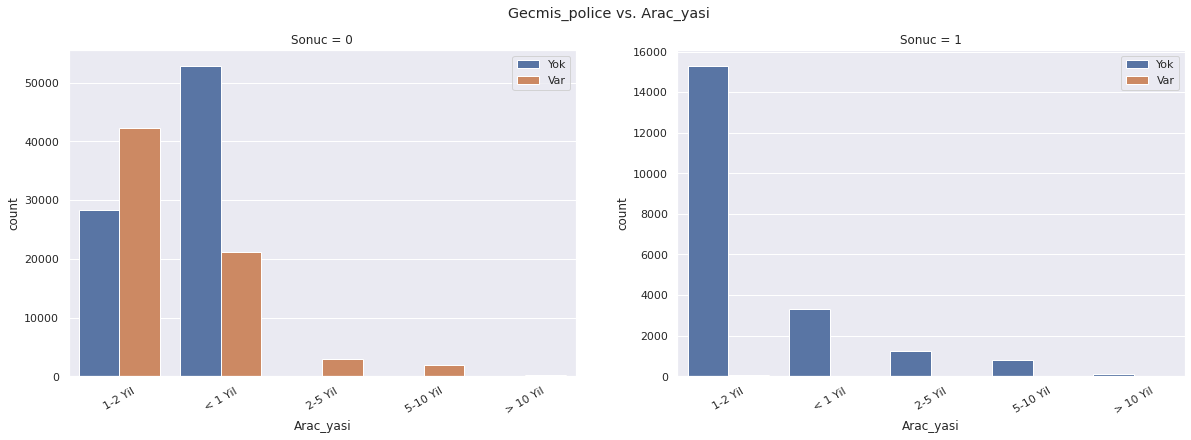

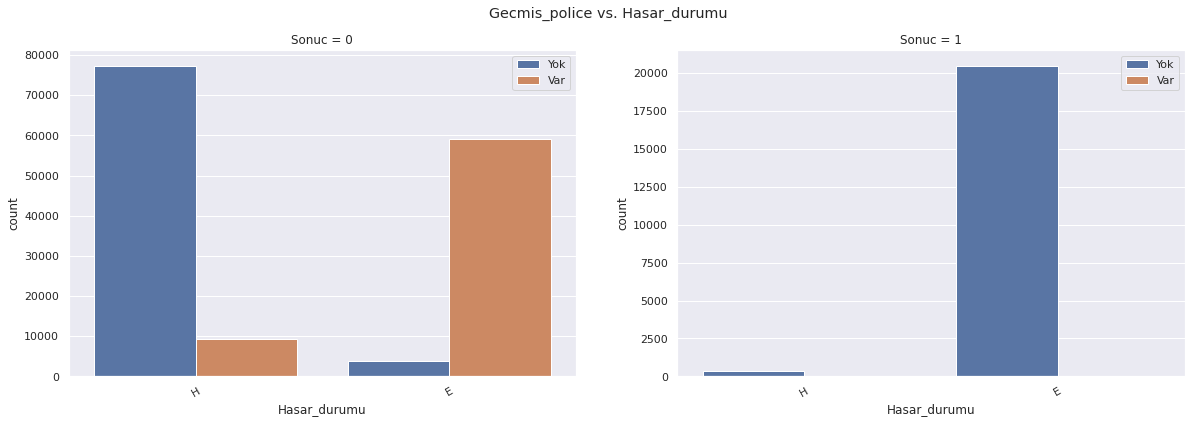

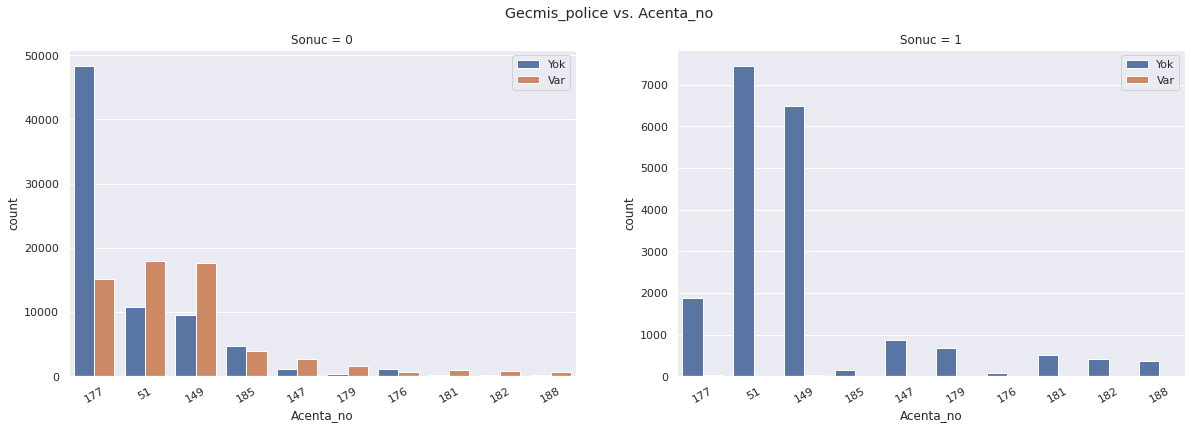

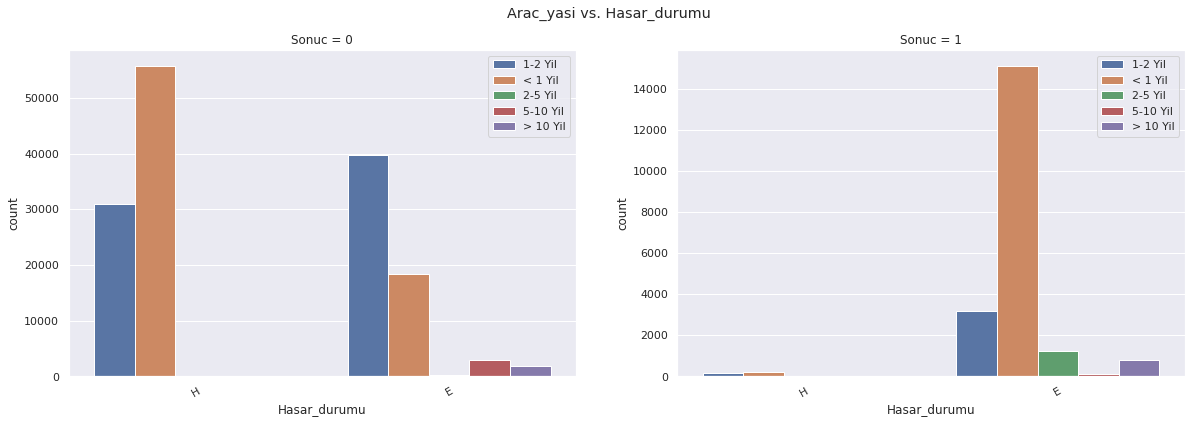

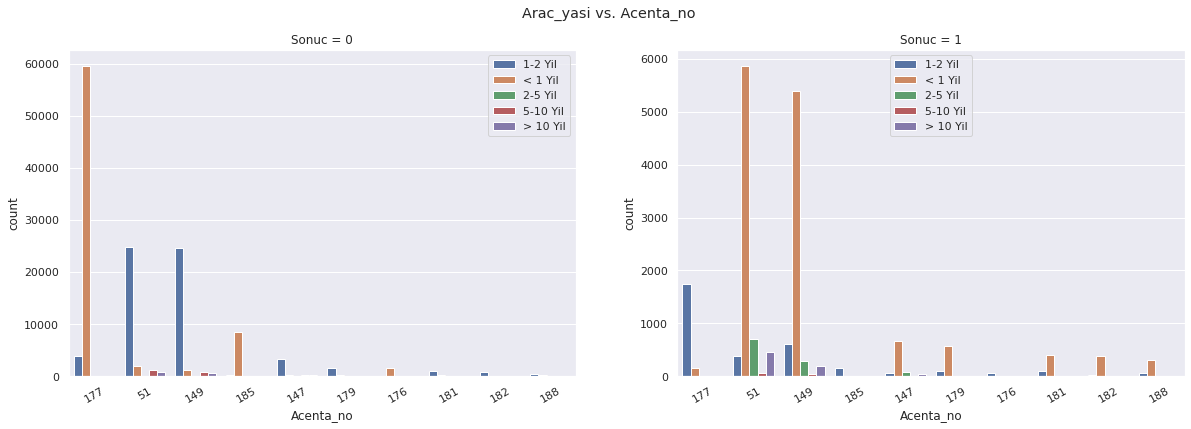

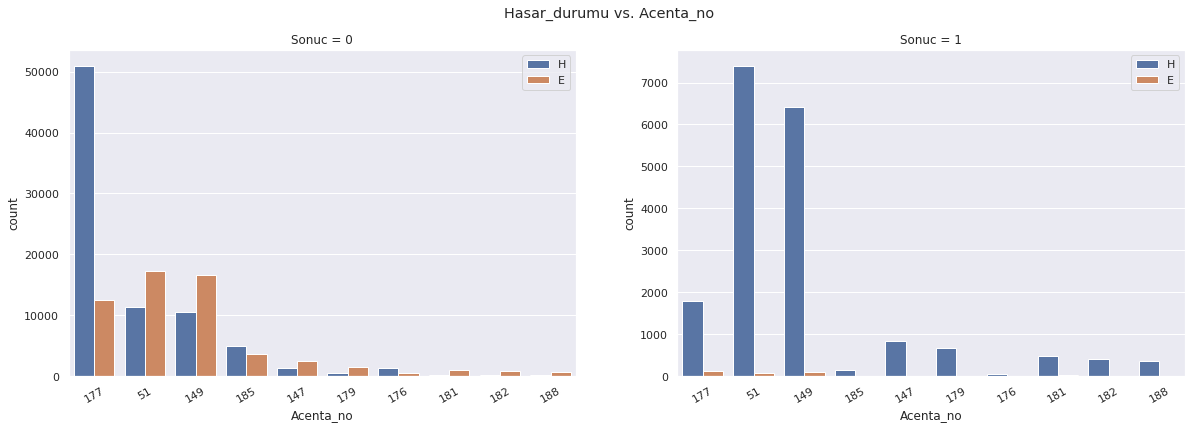

In [ ]:
from itertools import combinations

for col1, col2 in combinations(categoric_features, 2):
  fig, axes = plt.subplots(1,2, figsize=(20, 6))
  for i, j in enumerate(list(train_set["Sonuc"].unique())):
    sns.countplot(data = train_set[train_set["Sonuc"]== j][[col1, col2]], hue=col1, x=col2, ax=axes[i], order=train_set[col2].value_counts().iloc[:10].index)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)
    #axes[i].legend_.remove()
    axes[i].legend(train_set[col1].value_counts().iloc[:10].index)
    axes[i].set_title("Sonuc = {}".format(j))
    plt.suptitle("{} vs. {}".format(col1, col2))

* If the customer is male it will more likely to have a positive Hasar_durumu and higher intention to the company's offer.
* We can say that Acenta_no 51 and 149 have higher success rate for convincing the customers to have a accident policy.
* If the customer is female and if she has a previous accident, it is more likely to have intention on the company's offer.
* We also see that Hasar_durumu is concentrated on "1-2 year" vehicles altohugh majority vehicles are in "<1 year".

*Numeric Features*

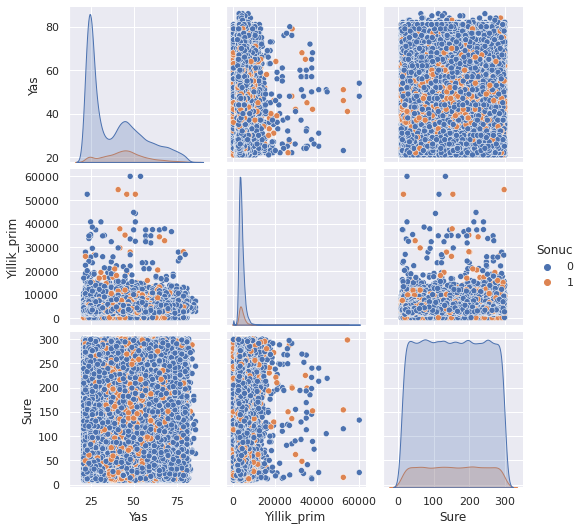

In [ ]:
sns.pairplot(data=train_set[numeric_features + ["Sonuc"]], hue="Sonuc")

We see that there is no visible pattern among the numeric features.

*Numeric vs. Categorical Features*

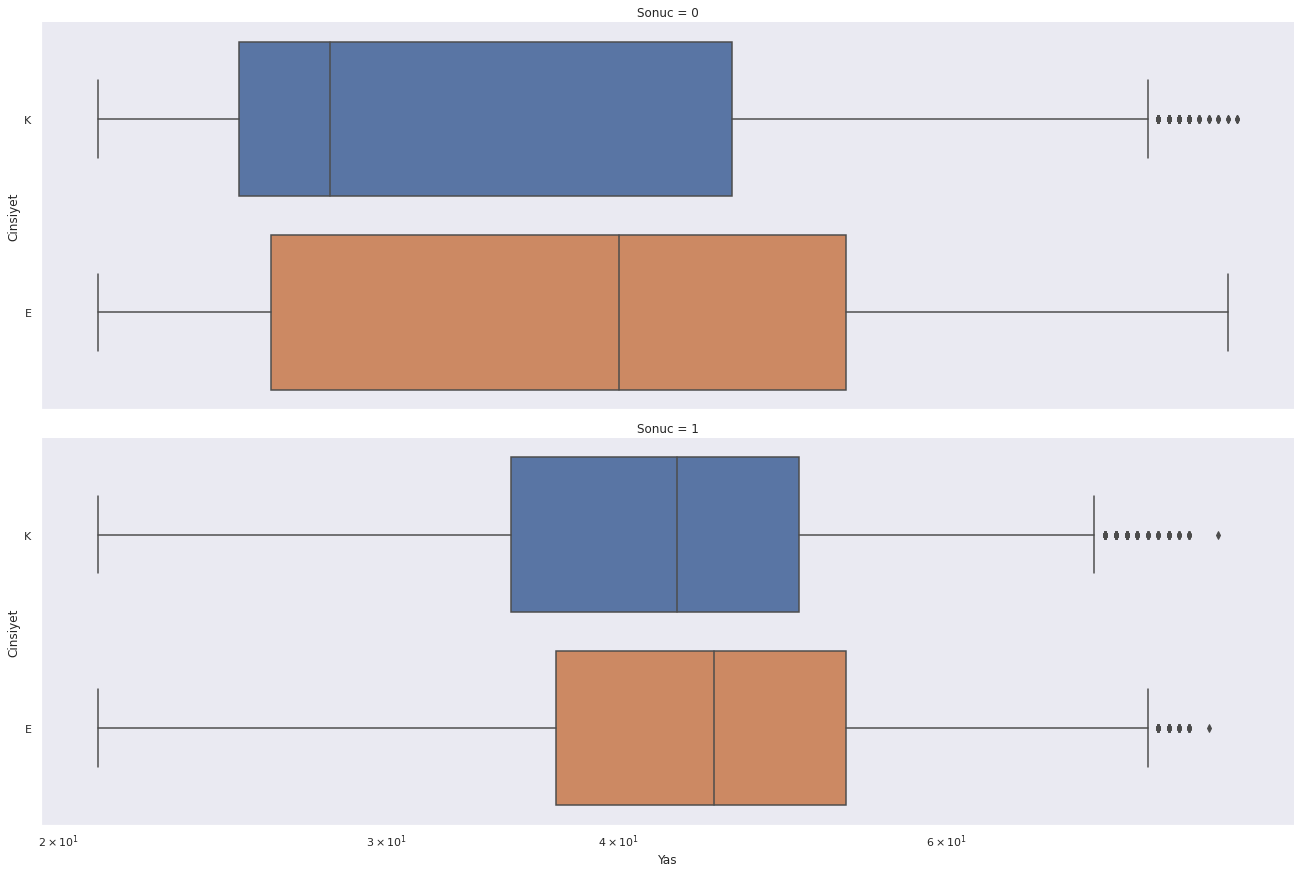

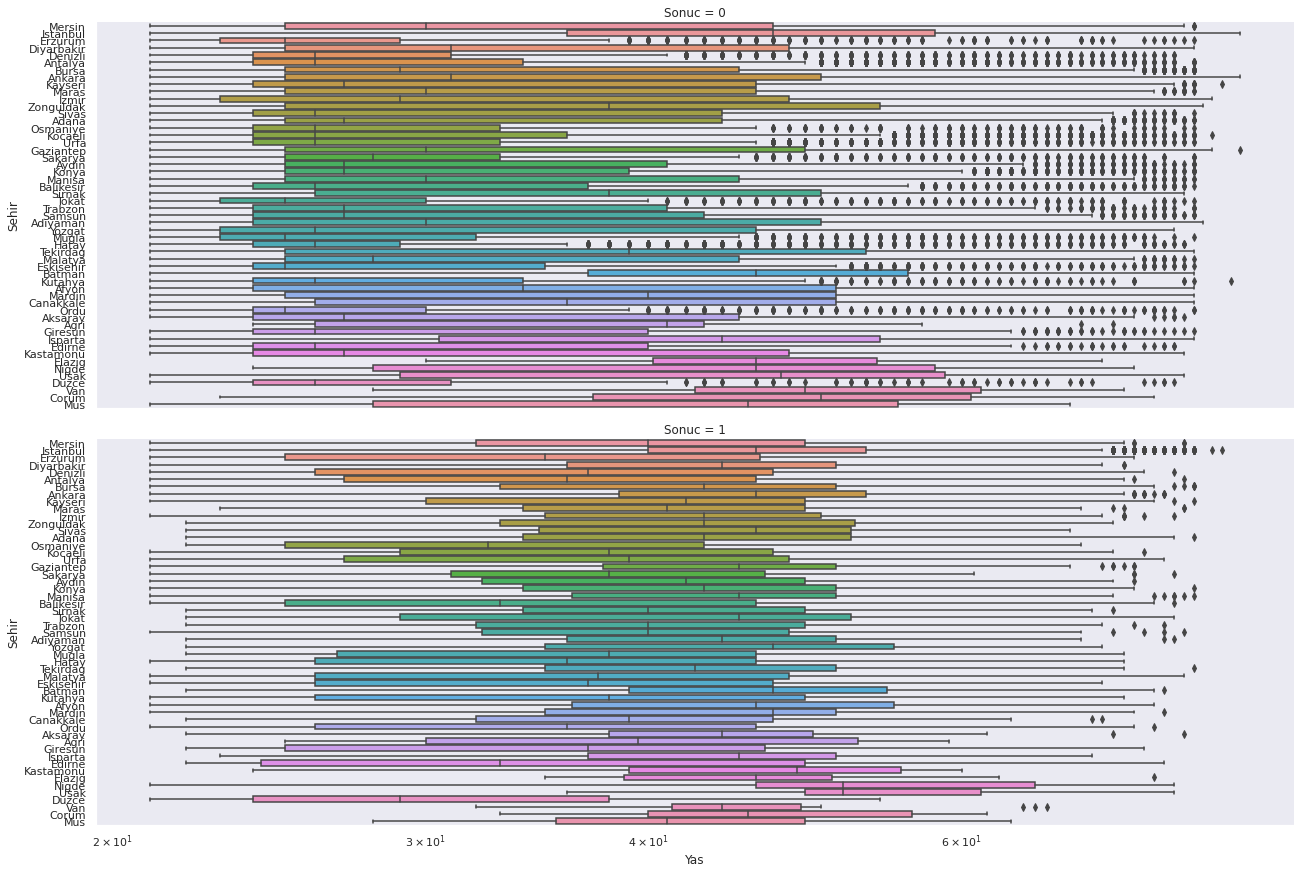

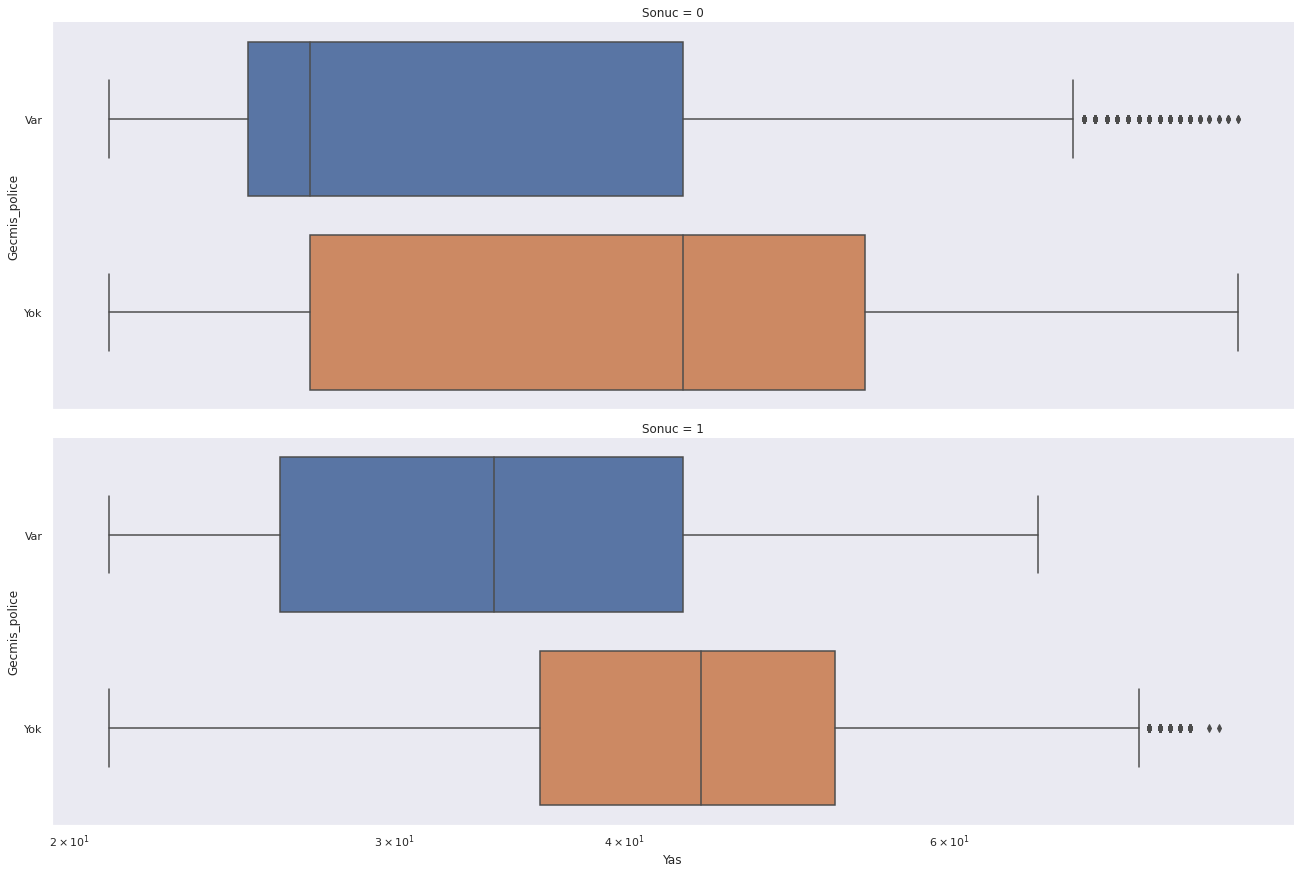

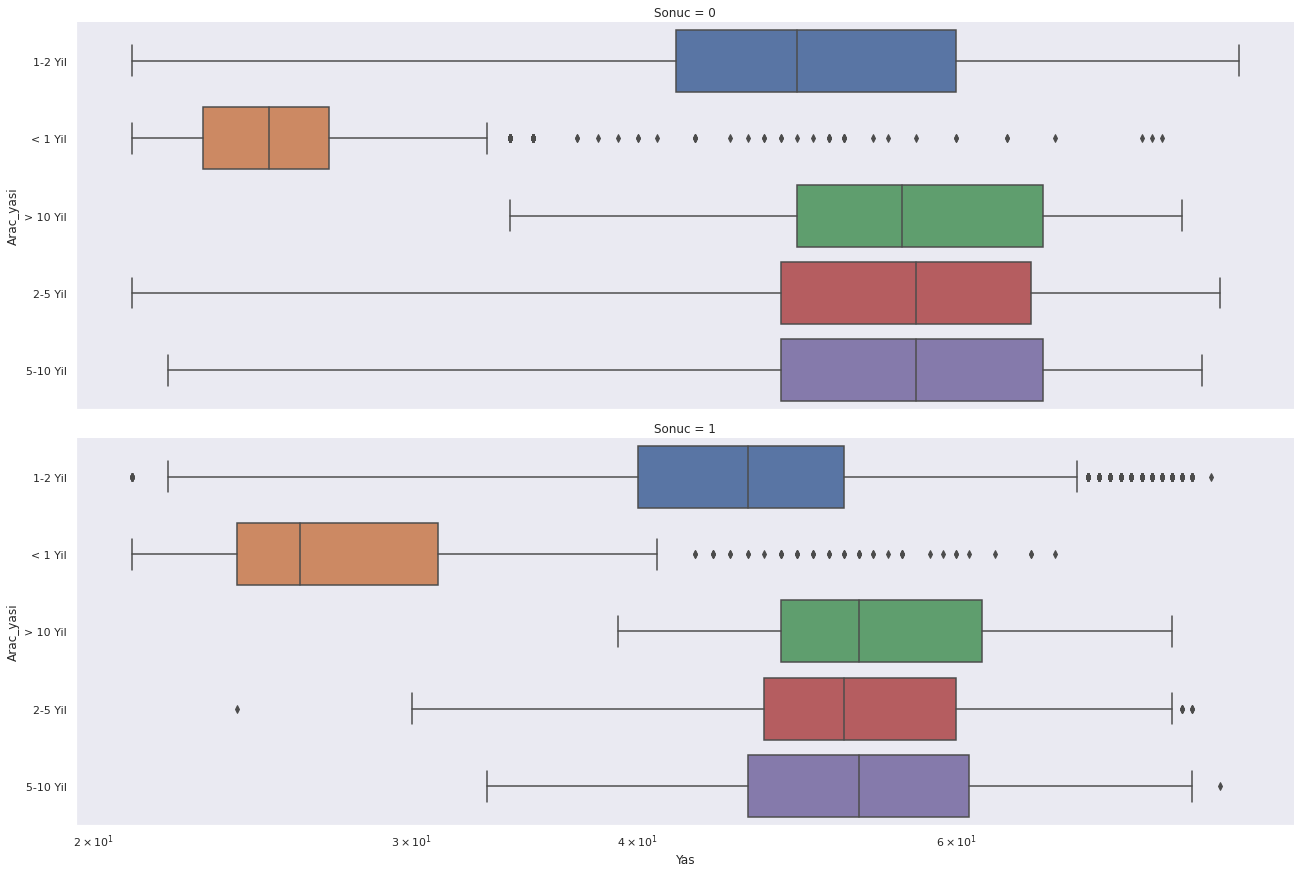

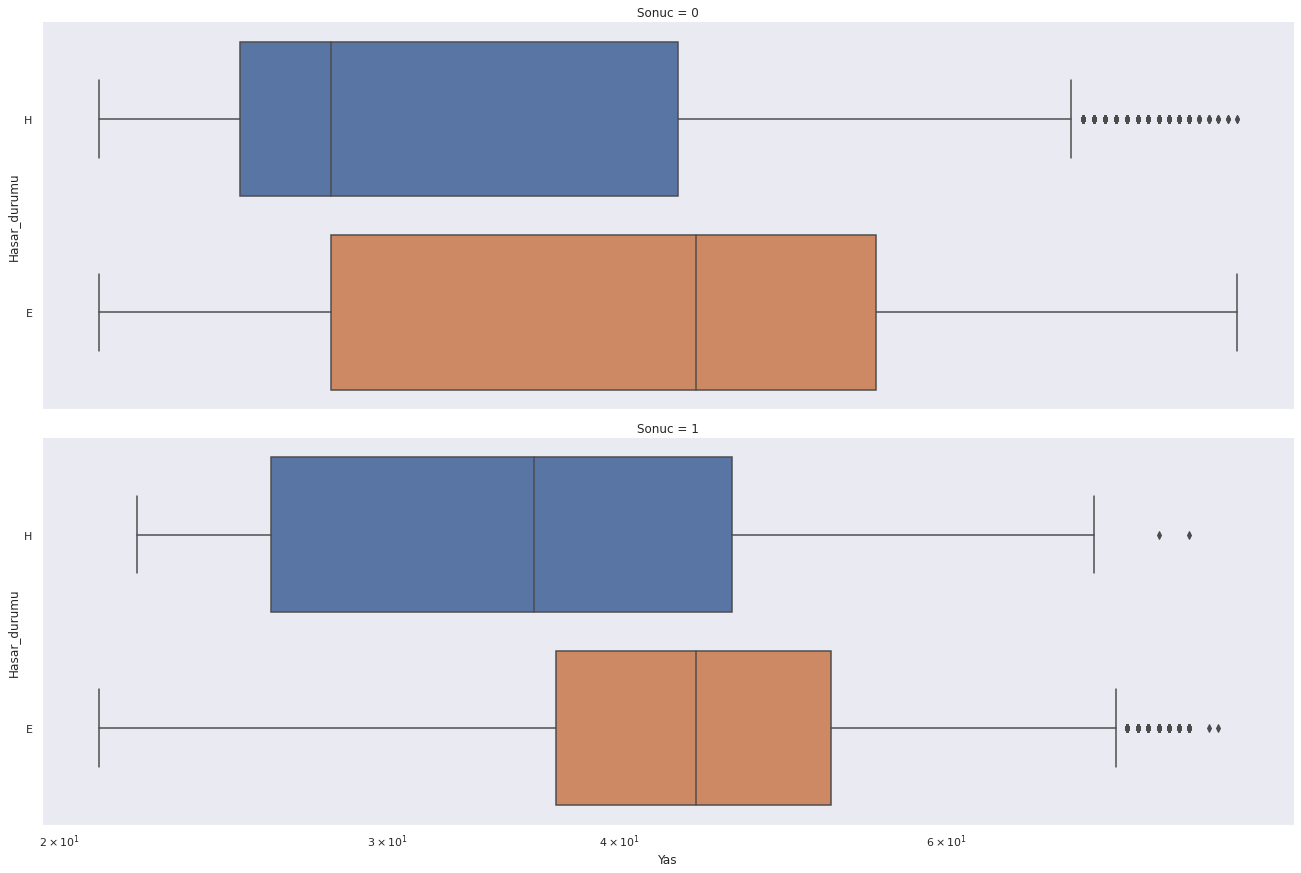

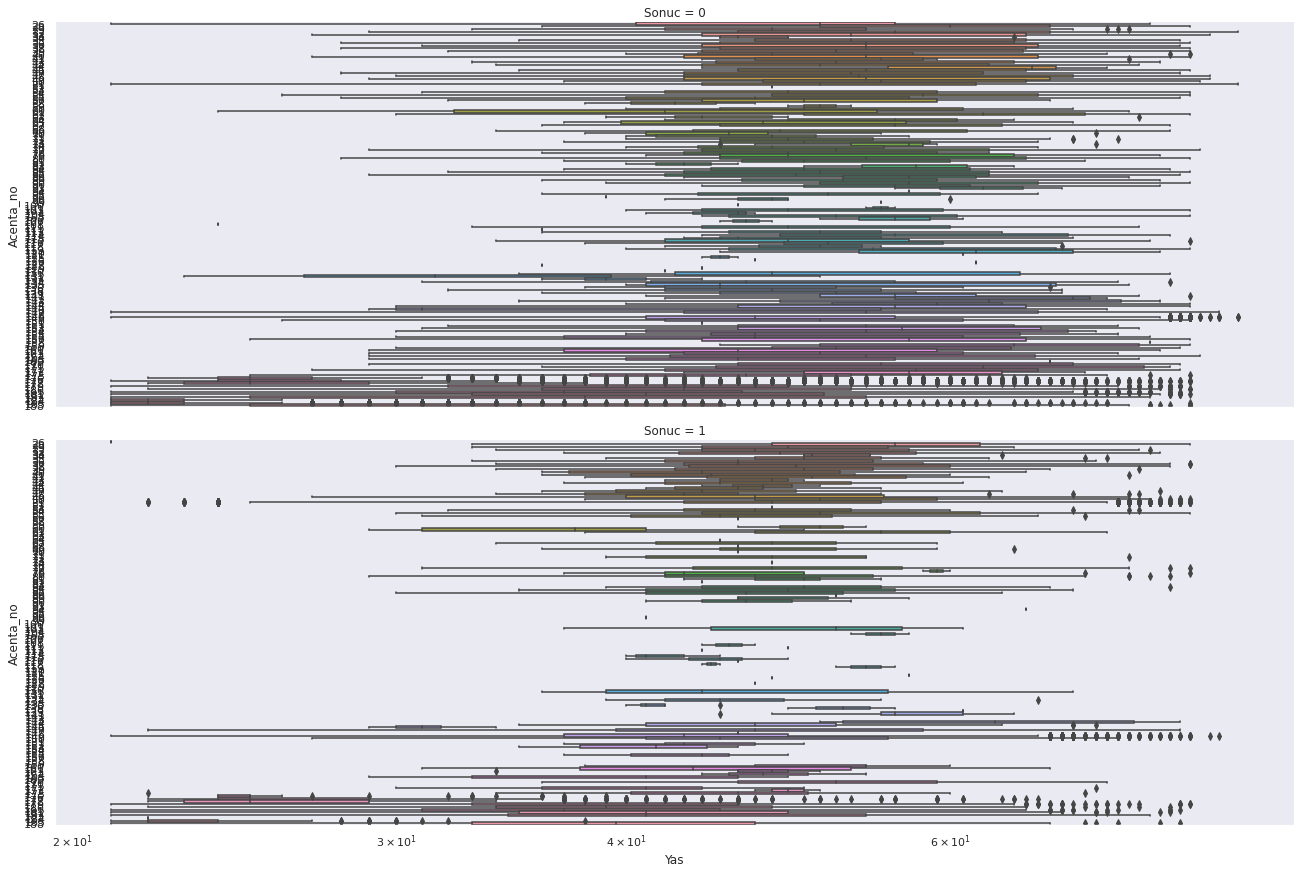

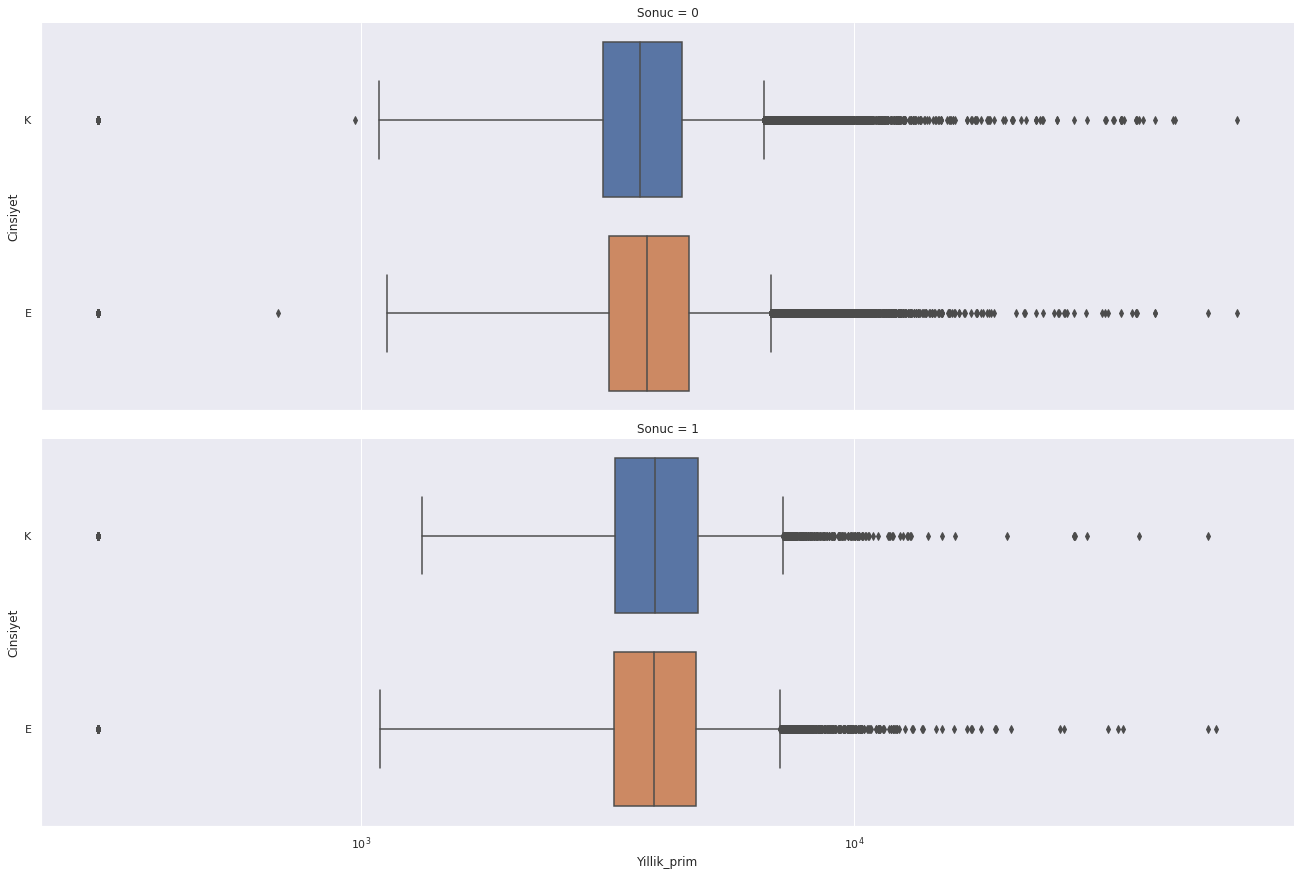

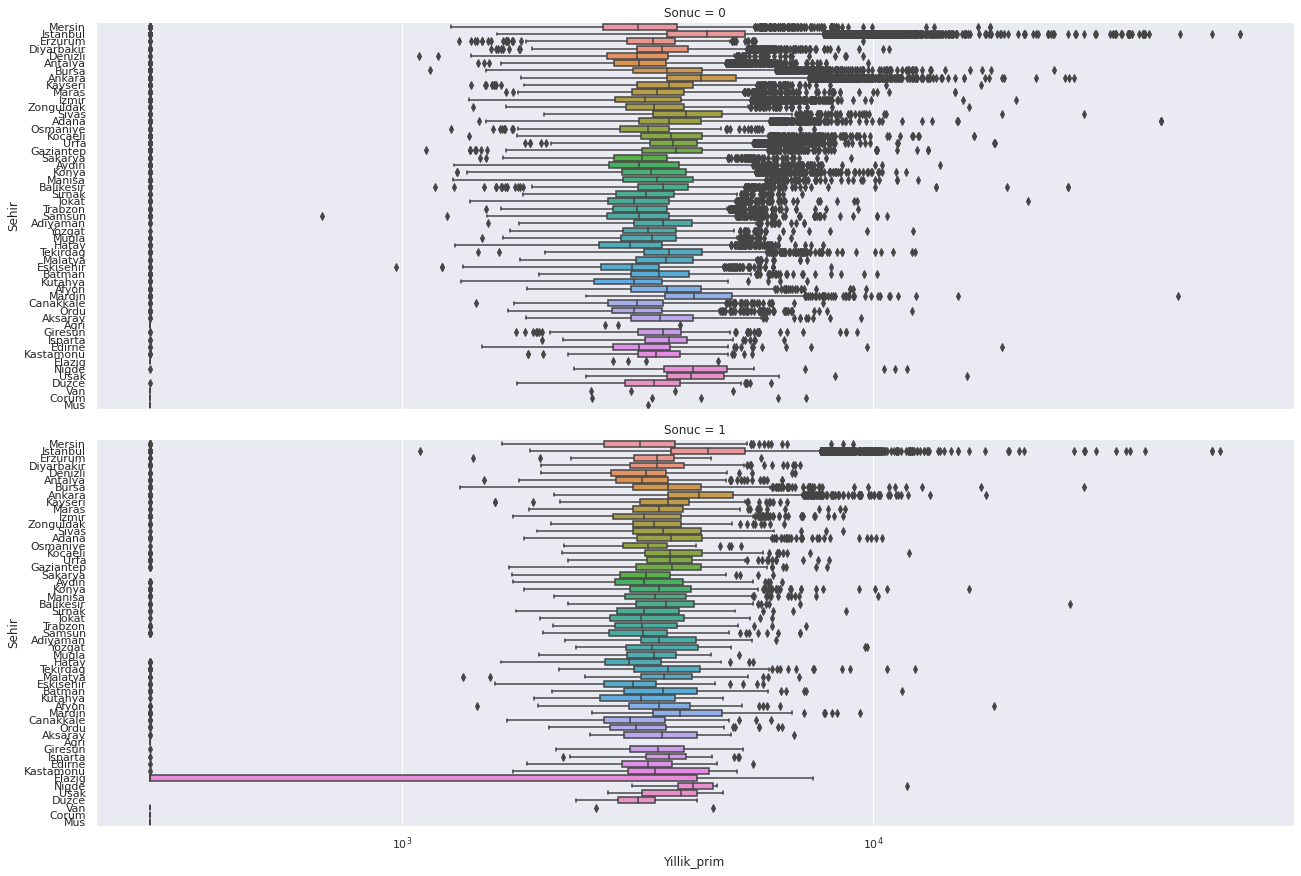

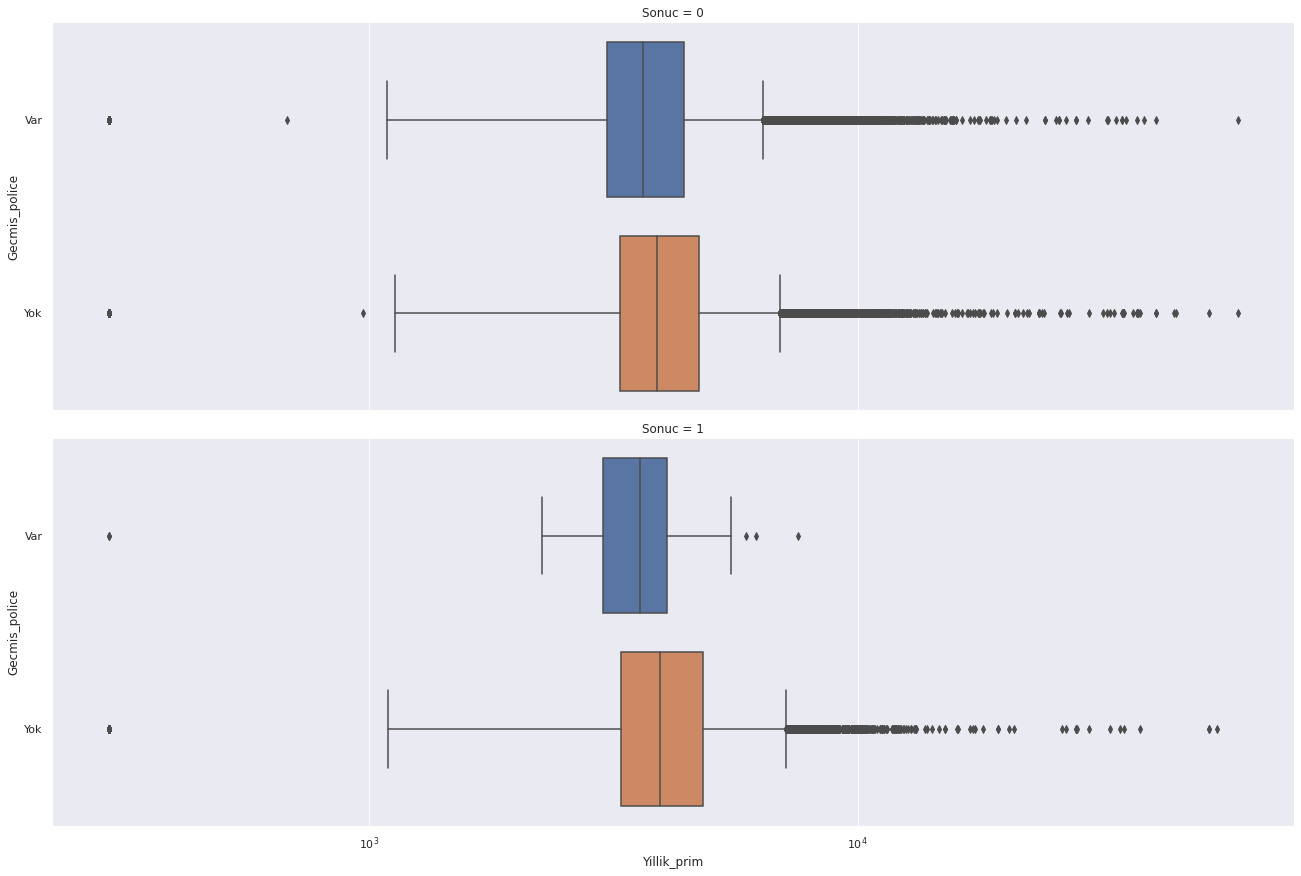

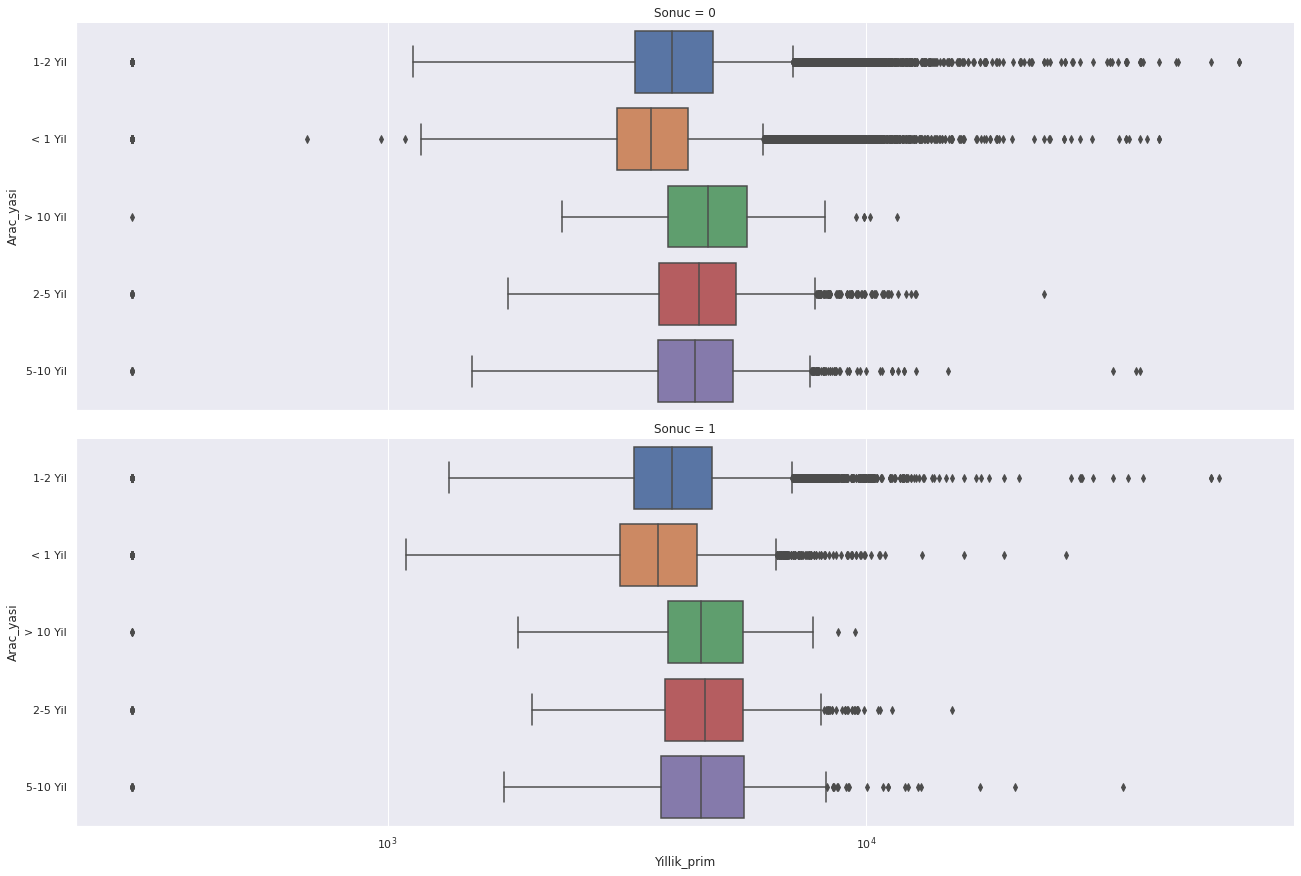

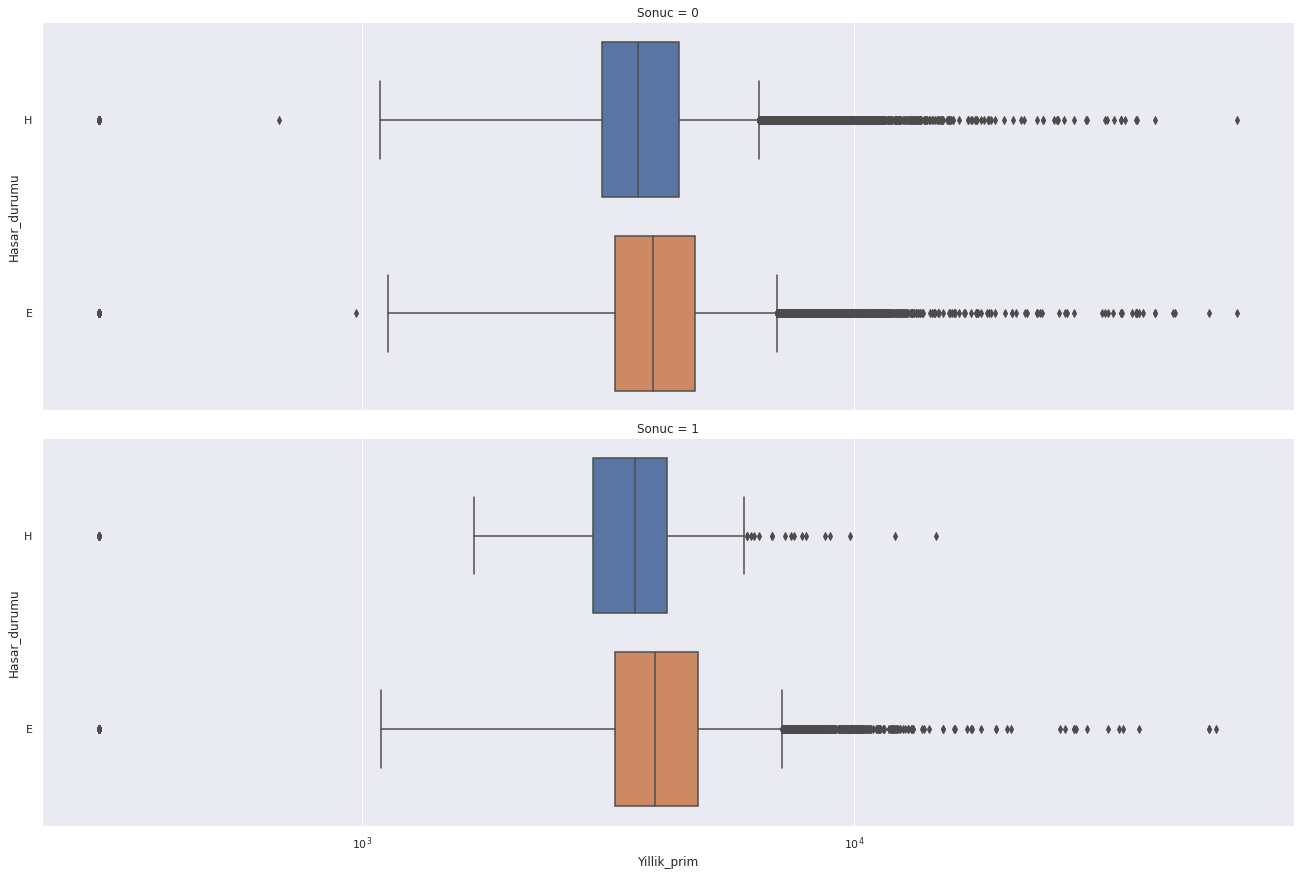

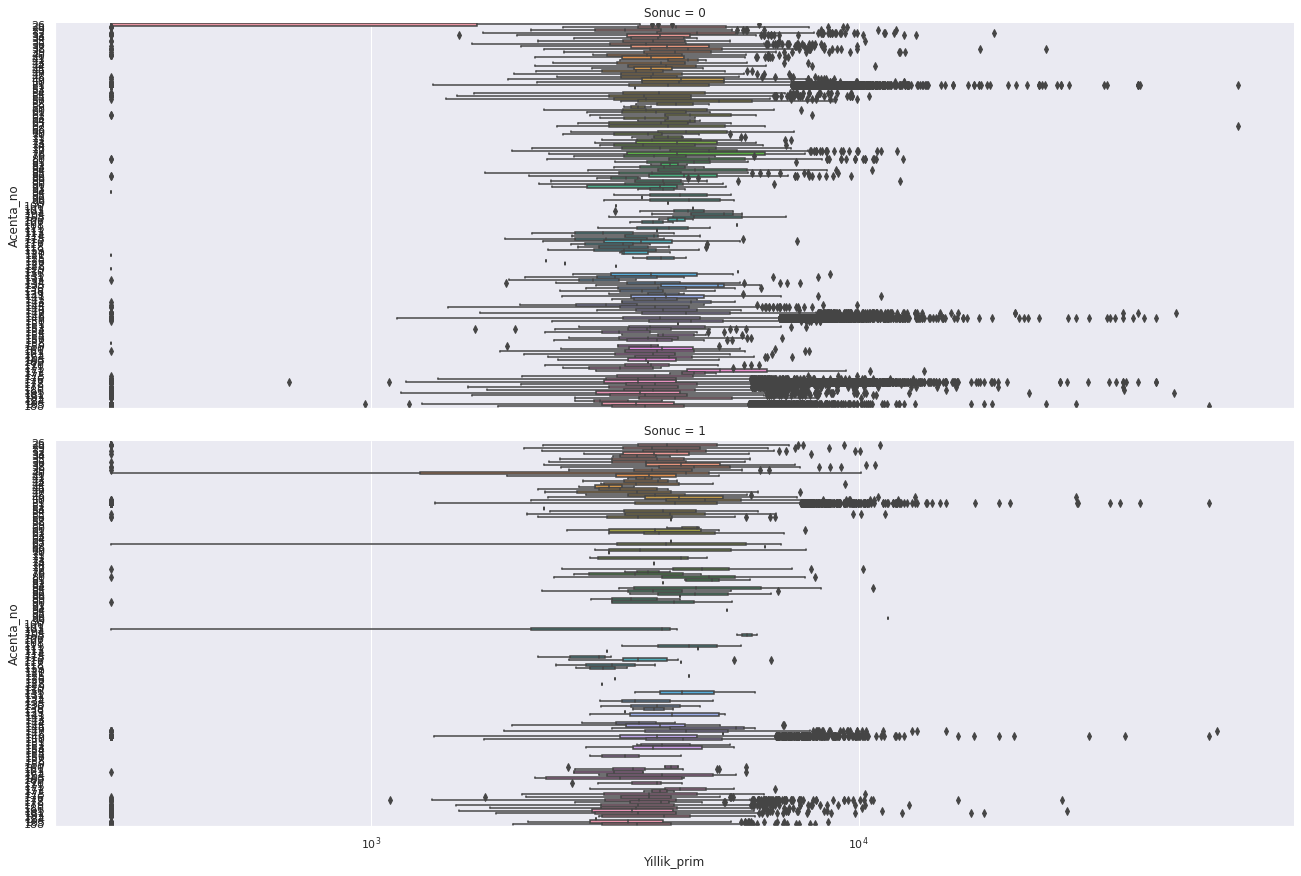

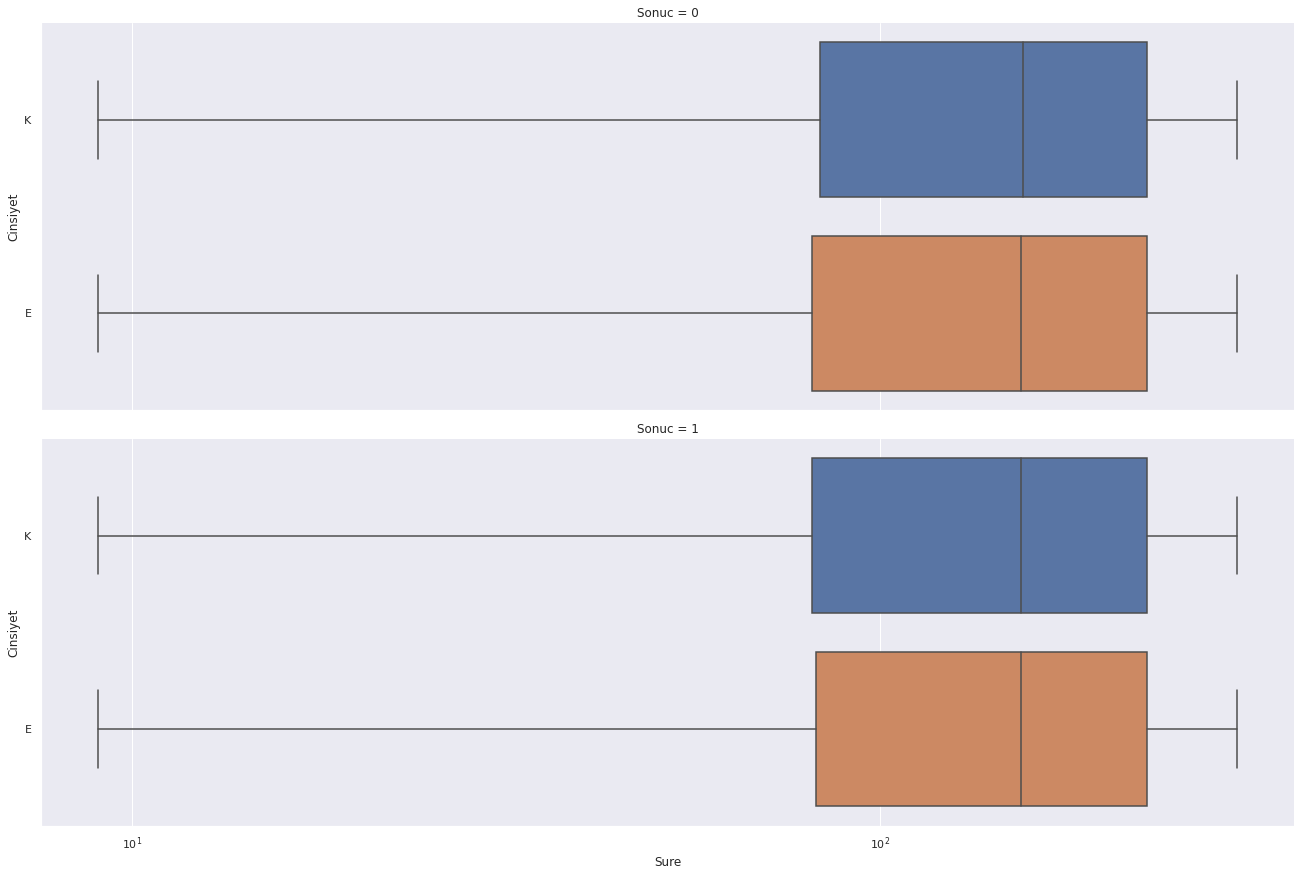

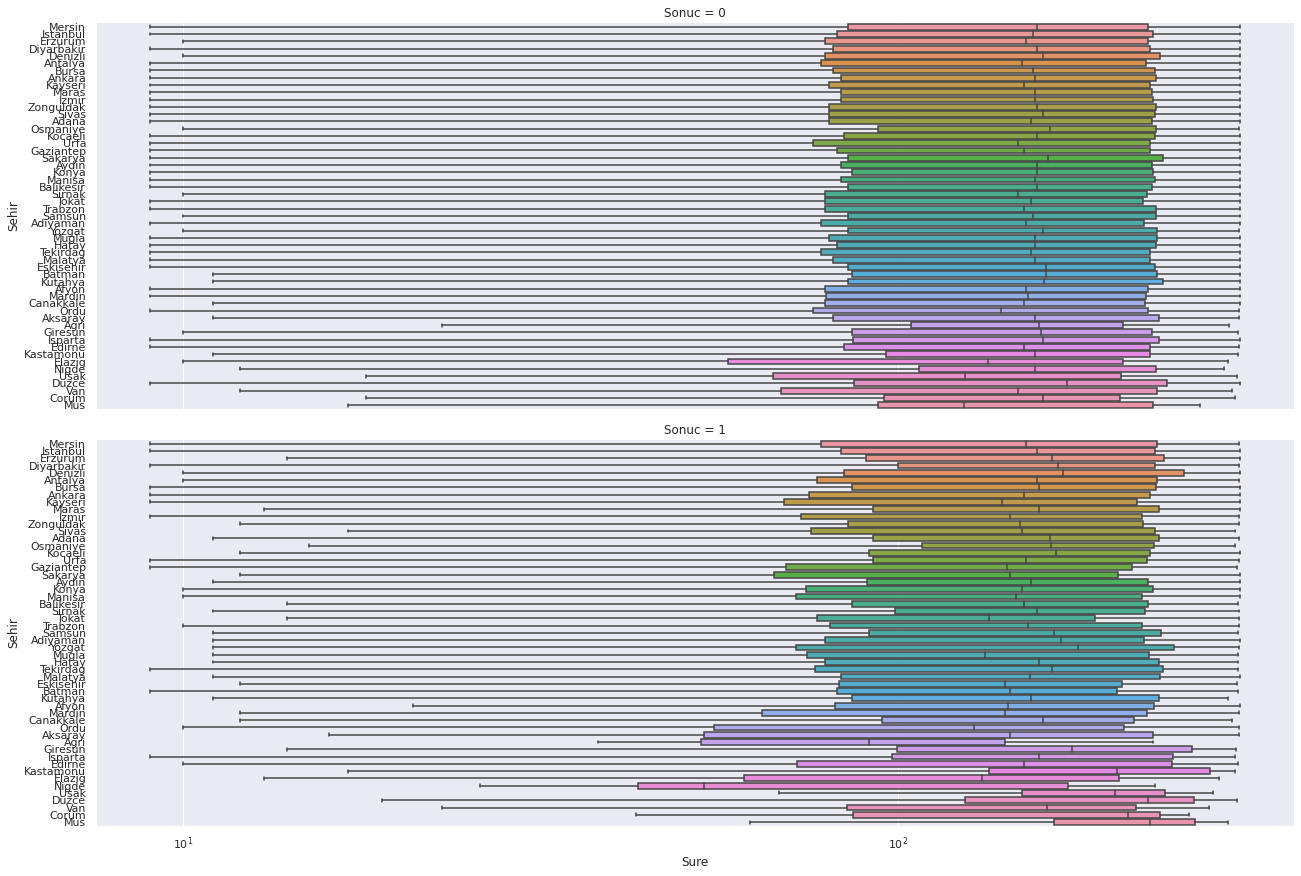

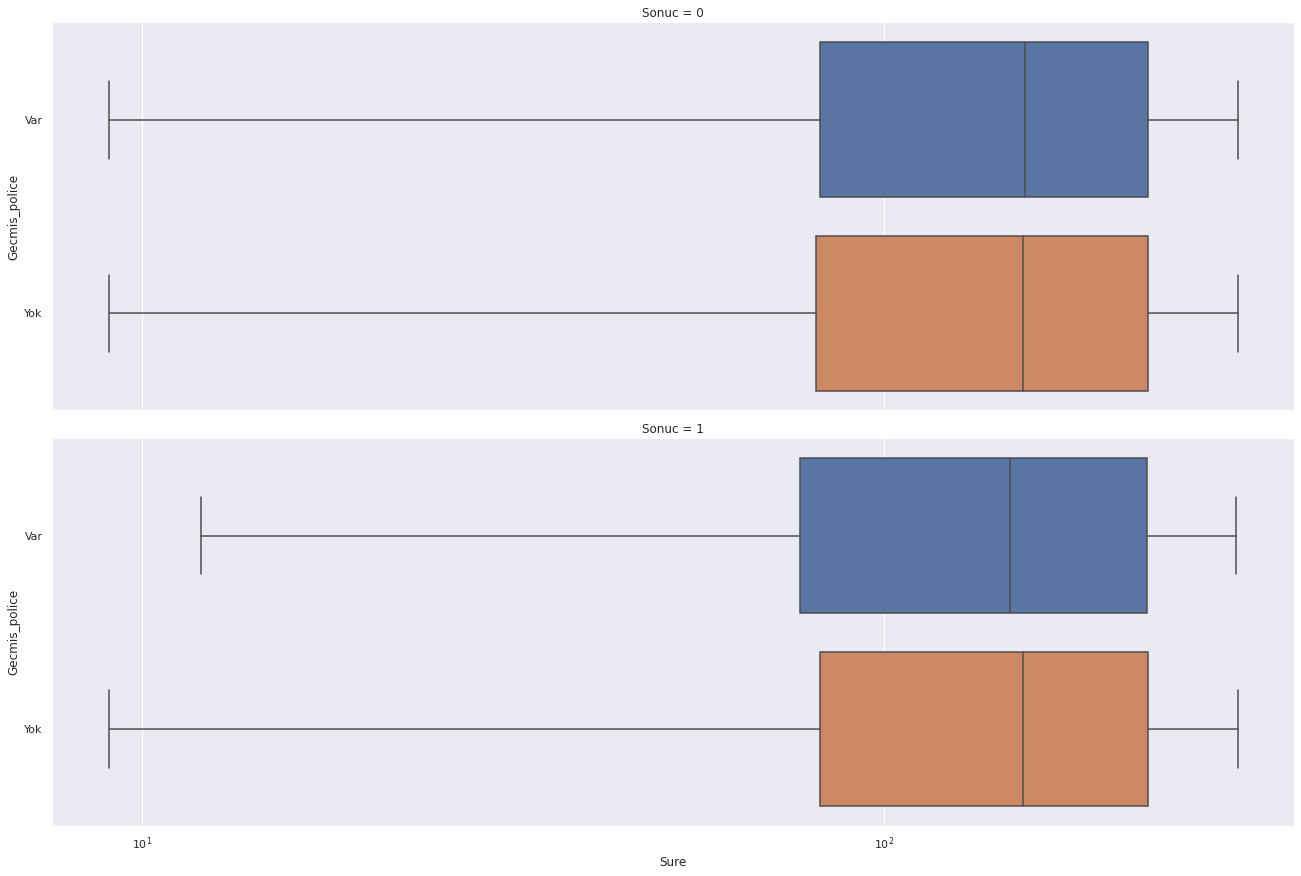

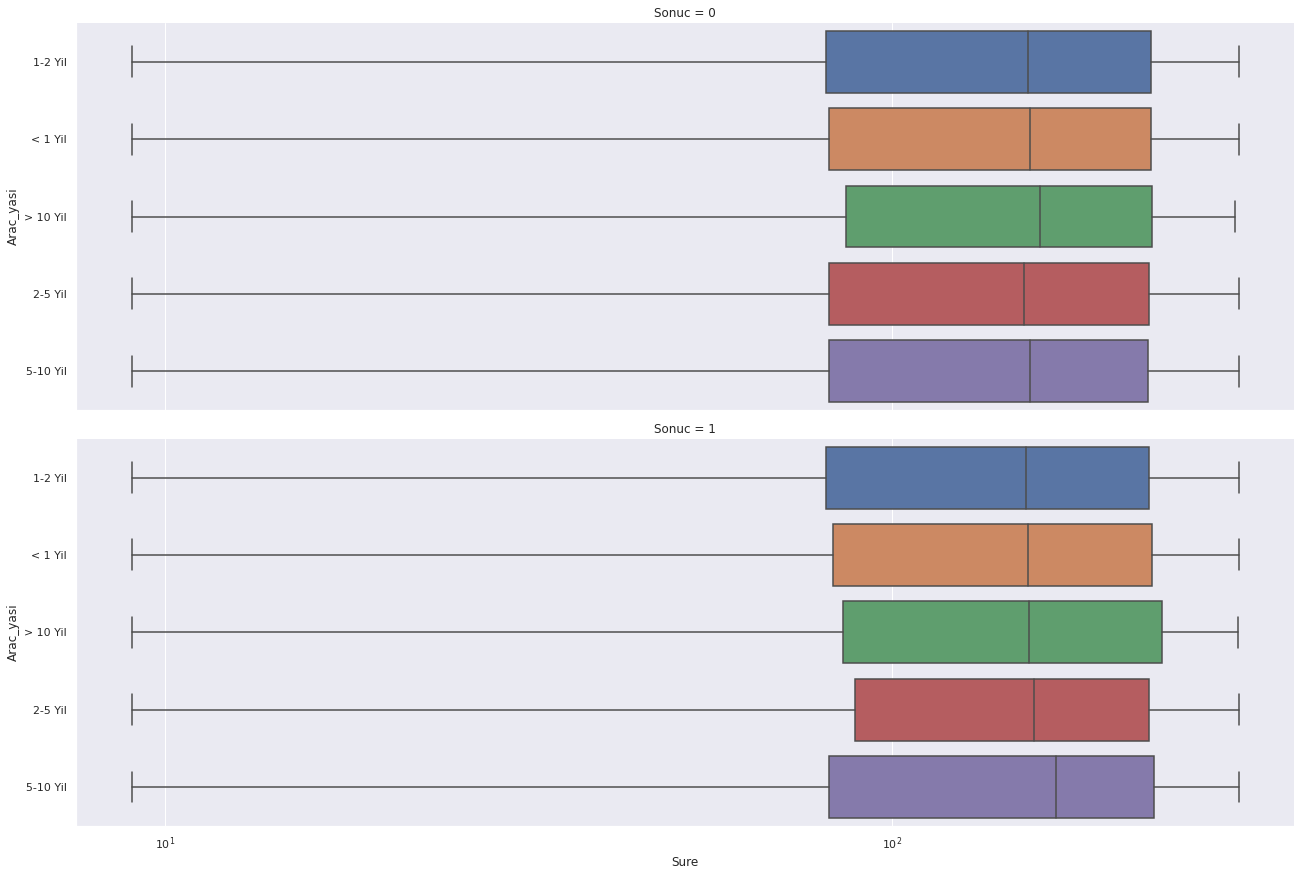

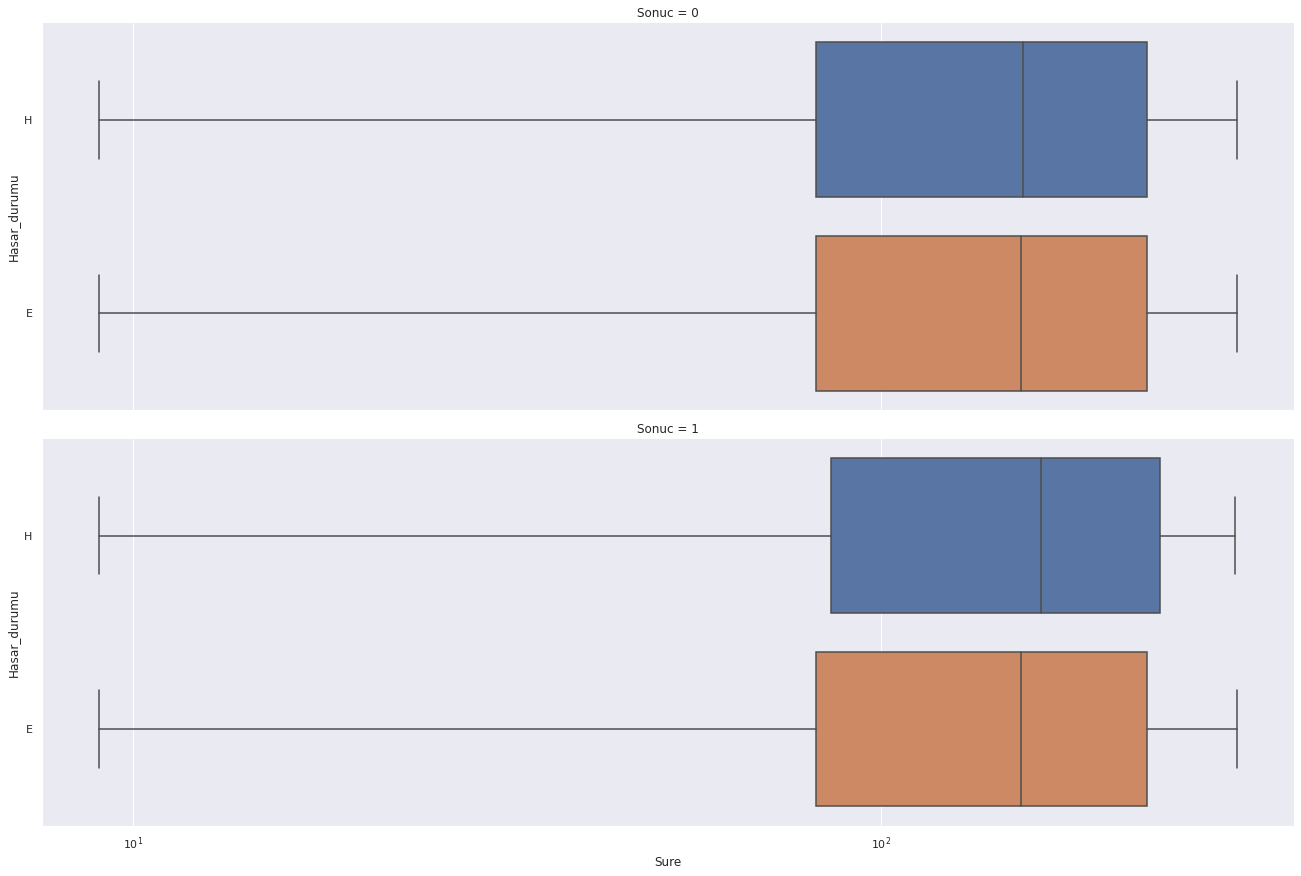

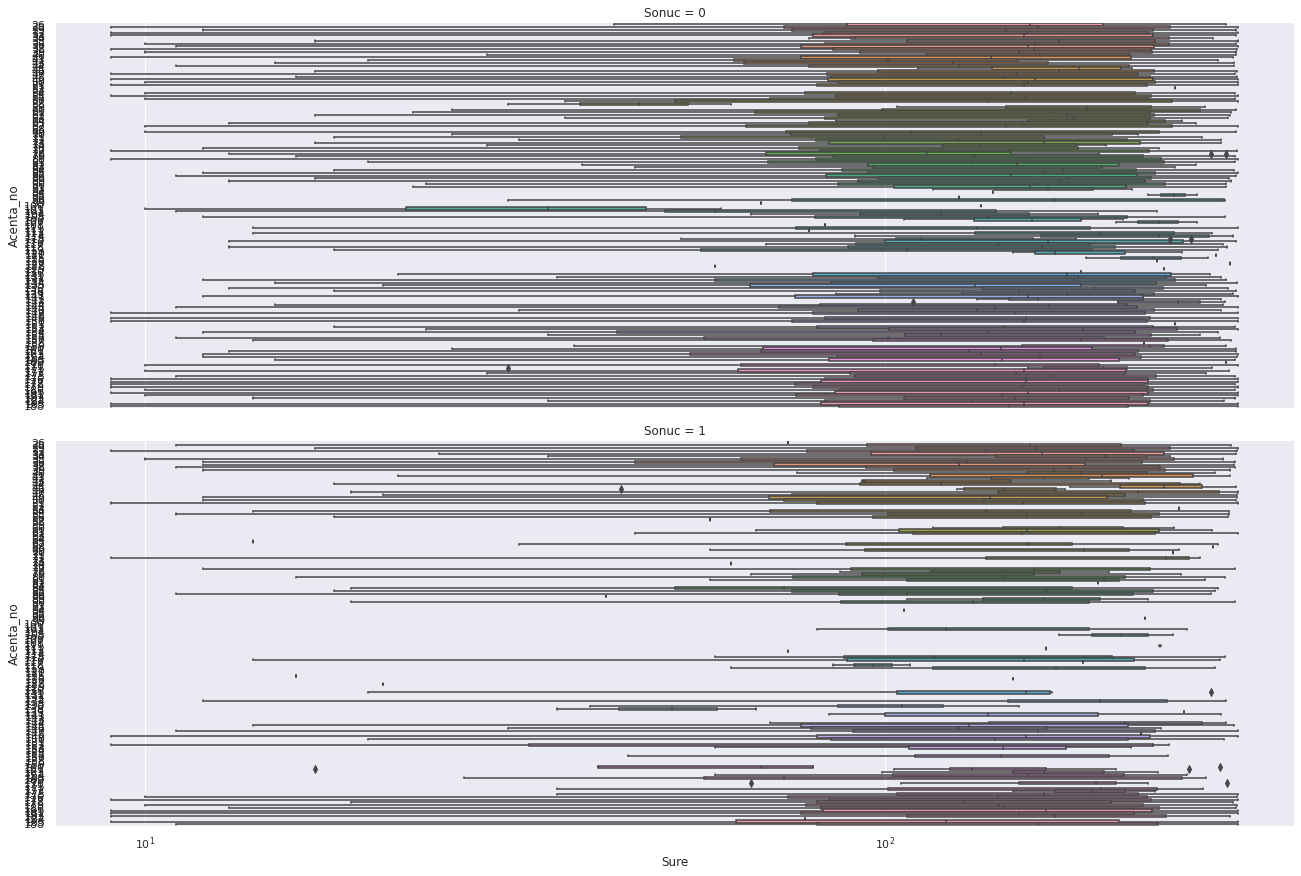

In [ ]:
from itertools import product
for i, j in list(product(numeric_features,categoric_features)):
  g = sns.catplot(x=i, y=j, row="Sonuc",
                  kind="box", orient="h", height=6, aspect=1.5,
                  data=train_set)
  g.set(xscale="log")

**Correlation Analysis**

*Pearson Correlation of the Numeric Features*

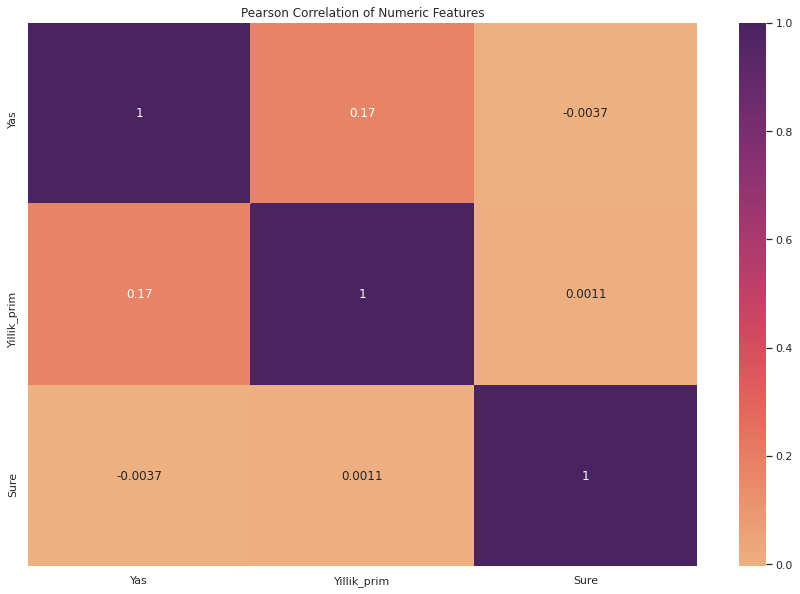

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(X_train.corr(),cmap="flare", annot=True)
plt.title("Pearson Correlation of Numeric Features");

In [ ]:
from scipy import stats
for col in numeric_features:
  coef, p_val = stats.pointbiserialr(train_set[col], train_set["Sonuc"])
  print("\033[1mPoint-Biserial Correlation of the Numeric Features with Target")
  print()
  print(col, ":",coef)

Point-Biserial Correlation of the Numeric Features with Target

Yas : 0.12286590973719078
Point-Biserial Correlation of the Numeric Features with Target

Yillik_prim : 0.037340503989696475
Point-Biserial Correlation of the Numeric Features with Target

Sure : 0.0007155680768224888


*Correlation of the Categoric Features*

In [ ]:
from sklearn.metrics import matthews_corrcoef
from scipy.stats import chi2_contingency

binary_cols = []
multicat_cols = []

for i in categoric_features:
  if X_train[i].nunique() == 2:
    binary_cols.append(i)
  else:
    multicat_cols.append(i)    

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))    

#binary-binary : phi's coeffient
#multi-multi: cramer's v
#binary_multi: cramer's v

pairs = []
corrs = []
for col1, col2 in combinations(categoric_features, 2):
  if col1 in binary_cols and col2 in binary_cols:
    pairs.append([col1, col2])
    corrs.append(matthews_corrcoef(train_set[col1], train_set[col2]))
  else:
    pairs.append([col1, col2])
    corrs.append(cramers_v(train_set[col1], train_set[col2]))

for i in range(len(corrs)):
  print(pairs[i][0], "vs.", pairs[i][1],":", corrs[i])

Cinsiyet vs. Sehir : 0.07049664622252527
Cinsiyet vs. Gecmis_police : 0.0
Cinsiyet vs. Arac_yasi : 0.17261482560936983
Cinsiyet vs. Hasar_durumu : 0.04782581135004151
Cinsiyet vs. Acenta_no : 0.18944274064032152
Sehir vs. Gecmis_police : 0.256539193328938
Sehir vs. Arac_yasi : 0.21457410551982808
Sehir vs. Hasar_durumu : 0.2559007894221416
Sehir vs. Acenta_no : 0.14461931690087595
Gecmis_police vs. Arac_yasi : 0.39900665175948
Gecmis_police vs. Hasar_durumu : 0.0
Gecmis_police vs. Acenta_no : 0.446396973936516
Arac_yasi vs. Hasar_durumu : 0.41141455734504045
Arac_yasi vs. Acenta_no : 0.4452064543641341
Hasar_durumu vs. Acenta_no : 0.459400816082972


We split the categorical features into two sub-categories as binary and multicategorical features. Then we applied Phi's coefficient analysis on the binary-binary features and Cramer's V correlation analysis on the rest.

There is no highly correlated features among categorical features.

*Correlation of Categoric Features with the Target*

In [ ]:
varb = []
corr = []
target_string = train_set["Sonuc"].map({0: "H", 1: "E"})
for col in categoric_features:
  if col in binary_cols:
    varb.append(col)
    corr.append(matthews_corrcoef(target_string, train_set[col]))
  else:
    varb.append(col)
    corr.append(cramers_v(train_set["Sonuc"], train_set[col]))

for i in range(len(corr)):
  print("Target vs.", varb[i],":", corr[i])

Target vs. Cinsiyet : 0.02789611725613292
Target vs. Sehir : 0.15155560097048876
Target vs. Gecmis_police : 0.0
Target vs. Arac_yasi : 0.23220688356725255
Target vs. Hasar_durumu : 0.3676531982700663
Target vs. Acenta_no : 0.2744086142331749


**Feature Engineering**

In [ ]:
X_train['is_agent177'] = X_train["Acenta_no"].apply(lambda x: 1 if x == '177' else 0)
X_train['is_agentin_51_149'] = X_train["Acenta_no"].apply(lambda x: 1 if x in ('51','149') else 0)

X_test['is_agent177'] = X_test["Acenta_no"].apply(lambda x: 1 if x == '177' else 0)
X_test['is_agentin_51_149'] = X_test["Acenta_no"].apply(lambda x: 1 if x in ('51','149') else 0)

X_train['log_yas'] = X_train["Yas"].apply(lambda x: np.log1p(x))
X_test['log_yas'] = X_test["Yas"].apply(lambda x: np.log1p(x))

X_train = X_train.drop("Yas", axis=1)
X_test = X_test.drop("Yas", axis=1)


#X_train.drop("Acenta_no", axis=1)
#X_test.drop("Acenta_no", axis=1)

I created some features based on the eye-ball check of the features and their relationships both each other and the target.

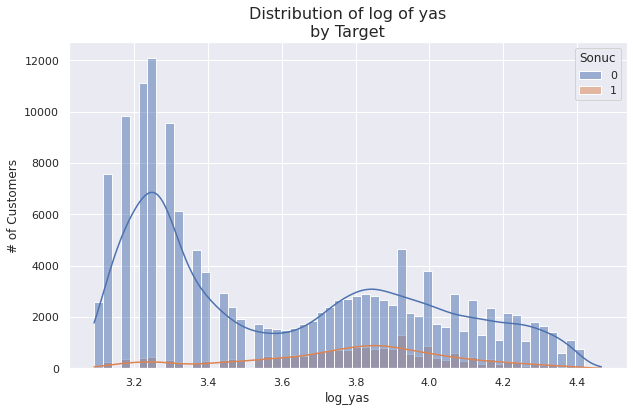

In [ ]:
  plt.figure(figsize=(10, 6))
  sns.histplot(data=pd.concat([X_train["log_yas"], y], axis=1), x='log_yas', hue='Sonuc', kde=True)
  plt.title('Distribution of {}\nby Target'.format("log of yas"), fontsize=16)
  plt.ylabel('# of Customers')
  plt.show()

Log transformation made the yas feature a little bit look like normal but still it is problematic.

**Model Building**

* Acenta_no, Sehir -> target_encoding
* Yas -> log of Yas
* Cinsiyet, Gecmis_police, Hasar_durumu, Arac_yasi -> onehot encoding
* Yillik_prim, Sure -> scale

In [ ]:
import sklearn.preprocessing as prep

**Model 1**

In [ ]:
seed = 42
target_enc_transformer = Pipeline(steps=[('encoder', ce.TargetEncoder())])
ohe_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first"))])
scale_transformer = Pipeline(steps=[("scaler", prep.PowerTransformer())])




preprocessor = ColumnTransformer(transformers=[('num', target_enc_transformer, ["Acenta_no", "Sehir"]),
                                               ('ohe', ohe_transformer, ["Cinsiyet", "Gecmis_police", "Hasar_durumu", "Arac_yasi"]),
                                               ('scaler', scale_transformer, ["Yillik_prim", "Sure"])
                                               ], remainder = 'passthrough') # preprocess numerical features and let the remaining ones pass through

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   RandomForestClassifier(random_state=seed))])

params = [{'classifier__n_estimators'      : [100, 150], 
           'classifier__max_features'      : ["sqrt"], 
           'classifier__criterion'         : ['entropy', "gini"], 
           'classifier__class_weight'      : ['balanced_subsample', "balanced"], 
           'classifier__max_depth'         : [10, 20],
           'classifier__min_samples_split' : [10],
           'classifier__min_samples_leaf'  : [3]
           }
         ]

grid_search = GridSearchCV(pipeline, param_grid = params, cv = 3, verbose = 0, n_jobs = -1, scoring="roc_auc")
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print("Best parameters:", grid_search.best_params_)
print()
print("Test Accuracy:",accuracy_score(y_test, y_pred))
print("Test ROC_AUC:",roc_auc_score(y_test, y_pred))
print()
print("Train Accuracy:",accuracy_score(y_train, grid_search.predict(X_train)))
print("Train ROC_AUC:",roc_auc_score(y_train, grid_search.predict(X_train)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Best parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Test Accuracy: 0.7134103537306508
Test ROC_AUC: 0.8083474209361361

Train Accuracy: 0.7124003750586029
Train ROC_AUC: 0.8109611864983219


In [ ]:
importances = grid_search.best_estimator_.named_steps["classifier"].feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = X_train.columns.tolist()
for i,j in zip(feature_names, importances):
  print(i,":", j)

Cinsiyet : 0.14036573266045138
Sehir : 0.046303060276192694
Gecmis_police : 0.00600805353907785
Arac_yasi : 0.2875606857611426
Hasar_durumu : 0.2500528400921438
Yillik_prim : 0.0022954721005232714
Acenta_no : 0.002690775367270507
Sure : 0.014608874530402858
is_agent177 : 0.0004654565660210586
is_agentin_51_149 : 0.06891393940407071
log_yas : 0.061855553624521165


**Model 2**

In [ ]:
seed = 42
target_enc_transformer = Pipeline(steps=[('encoder', ce.TargetEncoder())])
ohe_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first"))])
scale_transformer = Pipeline(steps=[("scaler", prep.PowerTransformer())])




preprocessor = ColumnTransformer(transformers=[('num', target_enc_transformer, ["Acenta_no", "Sehir"]),
                                               ('ohe', ohe_transformer, ["Cinsiyet", "Gecmis_police", "Hasar_durumu", "Arac_yasi"]),
                                               ('scaler', scale_transformer, ["Yillik_prim", "Sure"])
                                               ], remainder = 'passthrough') # preprocess numerical features and let the remaining ones pass through

pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   XGBClassifier(objective="binary:logistic", random_state=seed))])

params2 = [{ "classifier__colsample_bytree": [np.random.uniform(0.7, 0.3)],
             "classifier__gamma": [np.random.uniform(0, 0.5)],
             "classifier__learning_rate": [np.random.uniform(0.03, 0.3)], # default 0.1 
             "classifier__max_depth": [np.random.randint(2, 6)], # default 3
             "classifier__n_estimators": [np.random.randint(100, 150)], # default 100
             "classifier__subsample": [np.random.uniform(0.6, 0.4)]
          }]

grid_search2 = RandomizedSearchCV(pipeline2, param_distributions = params2, cv = 10, n_iter=20, verbose = 1, n_jobs = -1, scoring="roc_auc")
grid_search2.fit(X_train, y_train)
y_pred2 = grid_search2.predict(X_test)
print("Best parameters:", grid_search2.best_params_)
print()
print("Test Accuracy:",accuracy_score(y_test, y_pred2))
print("Test ROC_AUC:",roc_auc_score(y_test, y_pred2))
print()
print("Train Accuracy:",accuracy_score(y_train, grid_search2.predict(X_train)))
print("Train ROC_AUC:",roc_auc_score(y_train, grid_search2.predict(X_train)))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Best parameters: {'classifier__subsample': 0.4782156858346363, 'classifier__n_estimators': 148, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.06672897356354167, 'classifier__gamma': 0.07535718270690878, 'classifier__colsample_bytree': 0.5222794086808605}

Test Accuracy: 0.8777707711161612
Test ROC_AUC: 0.5041474880554423

Train Accuracy: 0.8782817627754337
Train ROC_AUC: 0.505452118458953


**Model 3**

In [ ]:
seed = 42
target_enc_transformer = Pipeline(steps=[('encoder', ce.TargetEncoder())])
ohe_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first"))])
scale_transformer = Pipeline(steps=[("scaler", prep.PowerTransformer())])




preprocessor = ColumnTransformer(transformers=[('num', target_enc_transformer, ["Acenta_no", "Sehir"]),
                                               ('ohe', ohe_transformer, ["Cinsiyet", "Gecmis_police", "Hasar_durumu", "Arac_yasi"]),
                                               ('scaler', scale_transformer, ["Yillik_prim", "Sure"])
                                               ], remainder = 'passthrough') # preprocess numerical features and let the remaining ones pass through

pipeline3 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   LGBMClassifier(random_state=seed))])

params3 = [{  'classifier__n_estimators': stats.randint(500, 1000),
              'classifier__learning_rate': stats.uniform(0.01, 0.6),
              'classifier__subsample': stats.uniform(0.5, 0.9),
              'classifier__max_depth': [6, 7, 8, 9, 15, 20],
              'classifier__colsample_bytree': stats.uniform(0.5, 0.9),
              'classifier__min_child_weight': [1, 2]
          }]

grid_search3 = RandomizedSearchCV(pipeline3, param_distributions = params3, cv = 5, n_iter=50, verbose = 1, n_jobs = -1, scoring="roc_auc")
grid_search3.fit(X_train, y_train)
y_pred3 = grid_search3.predict(X_test)
print("Best parameters:", grid_search3.best_params_)
print()
print("Test Accuracy:",accuracy_score(y_test, y_pred3))
print("Test ROC_AUC:",roc_auc_score(y_test, y_pred3))
print()
print("Train Accuracy:",accuracy_score(y_train, grid_search3.predict(X_train)))
print("Train ROC_AUC:",roc_auc_score(y_train, grid_search3.predict(X_train)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  9.8min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Best parameters: {'classifier__colsample_bytree': 0.6341475974147132, 'classifier__learning_rate': 0.01464385126443685, 'classifier__max_depth': 6, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 846, 'classifier__subsample': 0.5578711573539895}

Test Accuracy: 0.878151510464383
Test ROC_AUC: 0.5081348103173158

Train Accuracy: 0.8796237693389592
Train ROC_AUC: 0.5122002582897865


**Model 4**

In [ ]:
from imblearn.pipeline import Pipeline as imbpipe

preprocessor = ColumnTransformer(transformers=[('num', target_enc_transformer, ["Acenta_no", "Sehir"]),
                                               ('ohe', ohe_transformer, ["Cinsiyet", "Gecmis_police", "Hasar_durumu", "Arac_yasi"]),
                                               ('scaler', scale_transformer, ["Yillik_prim", "Sure"])
                                               ], remainder = 'passthrough') # preprocess numerical features and let the remaining ones pass through

pipeline4 = imbpipe(steps=[('preprocessor', preprocessor),
                           ('sampling',     SMOTE(random_state=seed)),
                           ('classifier',   RandomForestClassifier(random_state=seed))])


params4 = [{'classifier__class_weight': ["balanced_subsample"],
            'classifier__criterion': ['gini'],    
            "classifier__max_depth": [10],
            'classifier__max_features': ['sqrt'], 
            'classifier__min_samples_leaf': [2], 
            'classifier__min_samples_split': [10], 
            'classifier__n_estimators': [100]
           }]
 

grid_search4 = GridSearchCV(estimator=pipeline4, param_grid=params4, cv=5,  n_jobs=-1, verbose=1, scoring="roc_auc") 
grid_search4.fit(X_train, y_train)
y_pred4 = grid_search4.predict(X_test)
print("Best parameters:", grid_search4.best_params_)
print()
print("Test Accuracy:",accuracy_score(y_test, y_pred4))
print("Test ROC_AUC:",roc_auc_score(y_test, y_pred4))
print()
print("Train Accuracy:",accuracy_score(y_train, grid_search4.predict(X_train)))
print("Train ROC_AUC:",roc_auc_score(y_train, grid_search4.predict(X_train)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Test Accuracy: 0.734029769057789
Test ROC_AUC: 0.8034609052288049

Train Accuracy: 0.7344174871073605
Train ROC_AUC: 0.8062944639641387


**Model 5**

In [ ]:
#drop Yillik_prim, Acenta_no, is_agent177

X_train2 = X_train.drop(["Yillik_prim", "Acenta_no", "is_agent177"], axis=1)
X_test2 = X_test.drop(["Yillik_prim", "Acenta_no", "is_agent177"], axis=1)

seed = 42
target_enc_transformer = Pipeline(steps=[('encoder', ce.TargetEncoder())])
ohe_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first"))])
scale_transformer = Pipeline(steps=[("scaler", prep.PowerTransformer())])




preprocessor2 = ColumnTransformer(transformers=[('num', target_enc_transformer, ["Sehir"]),
                                               ('ohe', ohe_transformer, ["Cinsiyet", "Gecmis_police", "Hasar_durumu", "Arac_yasi"]),
                                               ('scaler', scale_transformer, ["Sure"])
                                               ], remainder = 'passthrough') # preprocess numerical features and let the remaining ones pass through

pipeline5 = imbpipe(steps=[('preprocessor', preprocessor2),
                           ('sampling',     SMOTE(random_state=seed)),
                           ('classifier',   RandomForestClassifier(random_state=seed))])


params5 = [{'classifier__class_weight': ["balanced_subsample"],
            'classifier__criterion': ['gini'],    
            "classifier__max_depth": [10],
            'classifier__max_features': ['sqrt'], 
            'classifier__min_samples_leaf': [2], 
            'classifier__min_samples_split': [10], 
            'classifier__n_estimators': [100]
           }]
 

grid_search5 = GridSearchCV(estimator=pipeline5, param_grid=params5, cv=5,  n_jobs=-1, verbose=1, scoring="roc_auc") 
grid_search5.fit(X_train2, y_train)
y_pred5 = grid_search5.predict(X_test2)
print("Best parameters:", grid_search5.best_params_)
print()
print("Test Accuracy:",accuracy_score(y_test, y_pred5))
print("Test ROC_AUC:",roc_auc_score(y_test, y_pred5))
print()
print("Train Accuracy:",accuracy_score(y_train, grid_search5.predict(X_train2)))
print("Train ROC_AUC:",roc_auc_score(y_train, grid_search5.predict(X_train2)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Test Accuracy: 0.7149214130189061
Test ROC_AUC: 0.8045579439007507

Train Accuracy: 0.7135431317393343
Train ROC_AUC: 0.8046792991271199


**Model 6**

In [ ]:
#drop Yillik_prim, Acenta_no, is_agent177

seed = 42
target_enc_transformer = Pipeline(steps=[('encoder', ce.TargetEncoder())])
ohe_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first"))])
scale_transformer = Pipeline(steps=[("scaler", prep.PowerTransformer())])




preprocessor2 = ColumnTransformer(transformers=[('num', target_enc_transformer, ["Sehir"]),
                                               ('ohe', ohe_transformer, ["Cinsiyet", "Gecmis_police", "Hasar_durumu", "Arac_yasi"]),
                                               ('scaler', scale_transformer, ["Sure"])
                                               ], remainder = 'passthrough') # preprocess numerical features and let the remaining ones pass through

pipeline6 = imbpipe(steps=[('preprocessor', preprocessor2),
                           ('sampling',     SMOTETomek(random_state=seed)),
                           ('classifier',   RandomForestClassifier(random_state=seed))])


params6 = [{'classifier__class_weight': ["balanced_subsample"],
            'classifier__criterion': ['gini'],    
            "classifier__max_depth": [10],
            'classifier__max_features': ['sqrt'], 
            'classifier__min_samples_leaf': [2], 
            'classifier__min_samples_split': [10], 
            'classifier__n_estimators': [100]
           }]
 

grid_search6 = GridSearchCV(estimator=pipeline6, param_grid=params6, cv=5,  n_jobs=-1, verbose=1, scoring="roc_auc") 
grid_search6.fit(X_train2, y_train)
y_pred6 = grid_search6.predict(X_test2)
print("Best parameters:", grid_search6.best_params_)
print()
print("Test Accuracy:",accuracy_score(y_test, y_pred6))
print("Test ROC_AUC:",roc_auc_score(y_test, y_pred6))
print()
print("Train Accuracy:",accuracy_score(y_train, grid_search6.predict(X_train2)))
print("Train ROC_AUC:",roc_auc_score(y_train, grid_search6.predict(X_train2)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.4min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Best parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}

Test Accuracy: 0.7137791949742406
Test ROC_AUC: 0.8043262463628458

Train Accuracy: 0.7121132208157525
Train ROC_AUC: 0.8046488524744306


**Model 8**

In [ ]:
seed = 42
target_enc_transformer = Pipeline(steps=[('encoder', ce.TargetEncoder())])
ohe_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first"))])
scale_transformer = Pipeline(steps=[("scaler", prep.PowerTransformer())])




preprocessor = ColumnTransformer(transformers=[('num', target_enc_transformer, ["Acenta_no", "Sehir"]),
                                               ('ohe', ohe_transformer, ["Cinsiyet", "Gecmis_police", "Hasar_durumu", "Arac_yasi"]),
                                               ('scaler', scale_transformer, ["Yillik_prim", "Sure"])
                                               ], remainder = 'passthrough') # preprocess numerical features and let the remaining ones pass through

pipeline8 = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier',   RandomForestClassifier(random_state=seed))])

params8 = [{'classifier__n_estimators'      : [90, 100], 
           'classifier__max_features'      : ["sqrt"], 
           'classifier__criterion'         : ['entropy', "gini"], 
           'classifier__class_weight'      : ['balanced_subsample', "balanced"], 
           'classifier__max_depth'         : [10, 20],
           'classifier__min_samples_split' : [5, 10],
           'classifier__min_samples_leaf'  : [2, 3]
           }
         ]

grid_search8 = GridSearchCV(pipeline8, param_grid = params8, cv = 3, verbose = 1, n_jobs = -1, scoring="roc_auc")
grid_search8.fit(X_train, y_train)
y_pred8 = grid_search8.predict(X_test)
print("Best parameters:", grid_search8.best_params_)
print()
print("Test Accuracy:",accuracy_score(y_test, y_pred8))
print("Test ROC_AUC:",roc_auc_score(y_test, y_pred8))
print()
print("Train Accuracy:",accuracy_score(y_train, grid_search8.predict(X_train)))
print("Train ROC_AUC:",roc_auc_score(y_train, grid_search8.predict(X_train)))

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 34.2min finished
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Best parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Test Accuracy: 0.7122562375813533
Test ROC_AUC: 0.8079413706677917

Train Accuracy: 0.7111228316924519
Train ROC_AUC: 0.8107699314578629


**Predicting the Test Data**

In [ ]:
print("Model 1:",roc_auc_score(y_test, y_pred))
print("Model 2:", roc_auc_score(y_test, y_pred2))
print("Model 3:", roc_auc_score(y_test, y_pred3))
print("Model 4:", roc_auc_score(y_test, y_pred4))
print("Model 5:", roc_auc_score(y_test, y_pred5))
print("Model 6:", roc_auc_score(y_test, y_pred6))
#print("Model 7:", roc_auc_score(y_test, y_pred7))
print("Model 8:", roc_auc_score(y_test, y_pred8))

Model 1: 0.8083474209361361
Model 2: 0.5041474880554423
Model 3: 0.5081348103173158
Model 4: 0.8034609052288049
Model 5: 0.8045579439007507
Model 6: 0.8043262463628458
Model 8: 0.8079413706677917


I tried different algorithms, feature generation, feature elimination and oversampling methods and we have model results and the best result belongs to the model 1. So This is the final submission model.

In [ ]:
#Final Model Submission
test_data = pd.read_excel("Arac_test.xlsx")
test_data2 = test_data.drop(["Musteri_no", "Ehliyet"], axis=1)
test_data2['is_agent177'] = test_data2["Acenta_no"].apply(lambda x: 1 if x == '177' else 0)
test_data2['is_agentin_51_149'] = test_data2["Acenta_no"].apply(lambda x: 1 if x in ('51','149') else 0)


test_data2['log_yas'] = test_data2["Yas"].apply(lambda x: np.log1p(x))
test_data2 = test_data2.drop("Yas", axis=1)
#test_data2 = test_data2.drop(["Yillik_prim", "Acenta_no"], axis=1)

test_data_preds = grid_search.predict(test_data2)
dfpred = pd.DataFrame(pd.Series(test_data_preds))
dfpred = dfpred.reset_index()
dfpred.columns = ["ID", "Prediction"]
dfpred["ID"] = dfpred["ID"] + 1 
# dfpred: dataframe for your predictions containing "ID" and "Prediction" fields
# How to write to a csv file 
dfpred.to_csv('pred.csv', index=False)

In [ ]:
#Alternative Model Submission
test_data = pd.read_excel("Arac_test.xlsx")
test_data2 = test_data.drop(["Musteri_no", "Ehliyet"], axis=1)
test_data2['is_agent177'] = test_data2["Acenta_no"].apply(lambda x: 1 if x == '177' else 0)
test_data2['is_agentin_51_149'] = test_data2["Acenta_no"].apply(lambda x: 1 if x in ('51','149') else 0)


test_data2['log_yas'] = test_data2["Yas"].apply(lambda x: np.log1p(x))
test_data2 = test_data2.drop("Yas", axis=1)
test_data2 = test_data2.drop(["Yillik_prim", "Acenta_no", "is_agent177"], axis=1)

test_data_preds2 = grid_search5.predict(test_data2)
dfpred2 = pd.DataFrame(pd.Series(test_data_preds2))
dfpred2 = dfpred2.reset_index()
dfpred2.columns = ["ID", "Prediction"]
dfpred2["ID"] = dfpred2["ID"] + 1 
# dfpred: dataframe for your predictions containing "ID" and "Prediction" fields
# How to write to a csv file 
dfpred2.to_csv('pred2.csv', index=False)